In [8]:
# bayes classifier over emotion dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer
from lib.dataset_utils import *
from sklearn.pipeline import Pipeline
from lib.plot_utils import plot_multilabel_confusion_heatmap, plot_score_barplot, get_scores_dict, custom_classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import os
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
DATASET = DatasetEnum.GoEmotionsCleaned
# load dataset
train_df, val_df, test_df = load_dataset(DATASET)
LABELS = train_df.columns[1:]
TEXT_COLUMN = 'text'

In [10]:
def bayes_analysis(train_df, val_df, classifier, text_col, label_cols):
    # train classifier
    classifier.fit(train_df[text_col], train_df[label_cols])
    # predict
    predictions_train = classifier.predict(train_df[text_col])
    predictions_val = classifier.predict(val_df[text_col])
    # convert to dataframe
    predictions_train = pd.DataFrame(predictions_train, columns=label_cols)
    predictions_val = pd.DataFrame(predictions_val, columns=label_cols)
    # calculate metrics
    print("Train metrics")
    scores_dict = get_scores_dict(predictions_train, train_df, label_cols)
    custom_classification_report(scores_dict, label_cols)
    print("Val metrics")
    scores_dict = get_scores_dict(predictions_val, val_df, label_cols)
    custom_classification_report(scores_dict, label_cols)
    # plot confusion matrix
    print("Train confusion matrix")
    plot_multilabel_confusion_heatmap(train_df[label_cols].to_numpy(), predictions_train.values, label_cols, label_cols, normalize=True)
    print("Val confusion matrix")
    plot_multilabel_confusion_heatmap(val_df[label_cols].to_numpy(), predictions_val.values, label_cols, label_cols, normalize=True)
    # bar plot over classes
    plot_score_barplot(train_df[label_cols], predictions_train, label_cols)
    plot_score_barplot(val_df[label_cols], predictions_val, label_cols)

In [11]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_content(text):
    # tokenize
    clean_text = nltk.word_tokenize(text)
    
    # pos tag
    clean_text = nltk.pos_tag(clean_text)
    TAG_MAP = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    clean_text = [(word, TAG_MAP.get(tag[0], 'n')) for word, tag in clean_text]

    # lemmatize
    clean_text = [lemmatizer.lemmatize(word, tag) for word, tag in clean_text]

    # remove punctuation marks
    clean_text = [w for w in clean_text if w not in string.punctuation]

    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

In [12]:
CLEAN_TEXT_COLUMN = 'clean_text'
train_df = clean_df(train_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
val_df = clean_df(val_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)
test_df = clean_df(test_df, TEXT_COLUMN, CLEAN_TEXT_COLUMN)

## One vs rest Bayes

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          1.00                0.02                0.04                0.02                4130
amusement                           0.92                0.00                0.01                0.00                2328
disapproval                         0.00                0.00                0.00                0.00                2022
disgust                             0.00                0.00                0.00                0.00                 793
embarrassment                       0.00                0.00                0.00                0.00                 303
excitement                          0.00                0.00                0.00                0.00                 853
fear                                0.00                0.00                0.00                0.00                

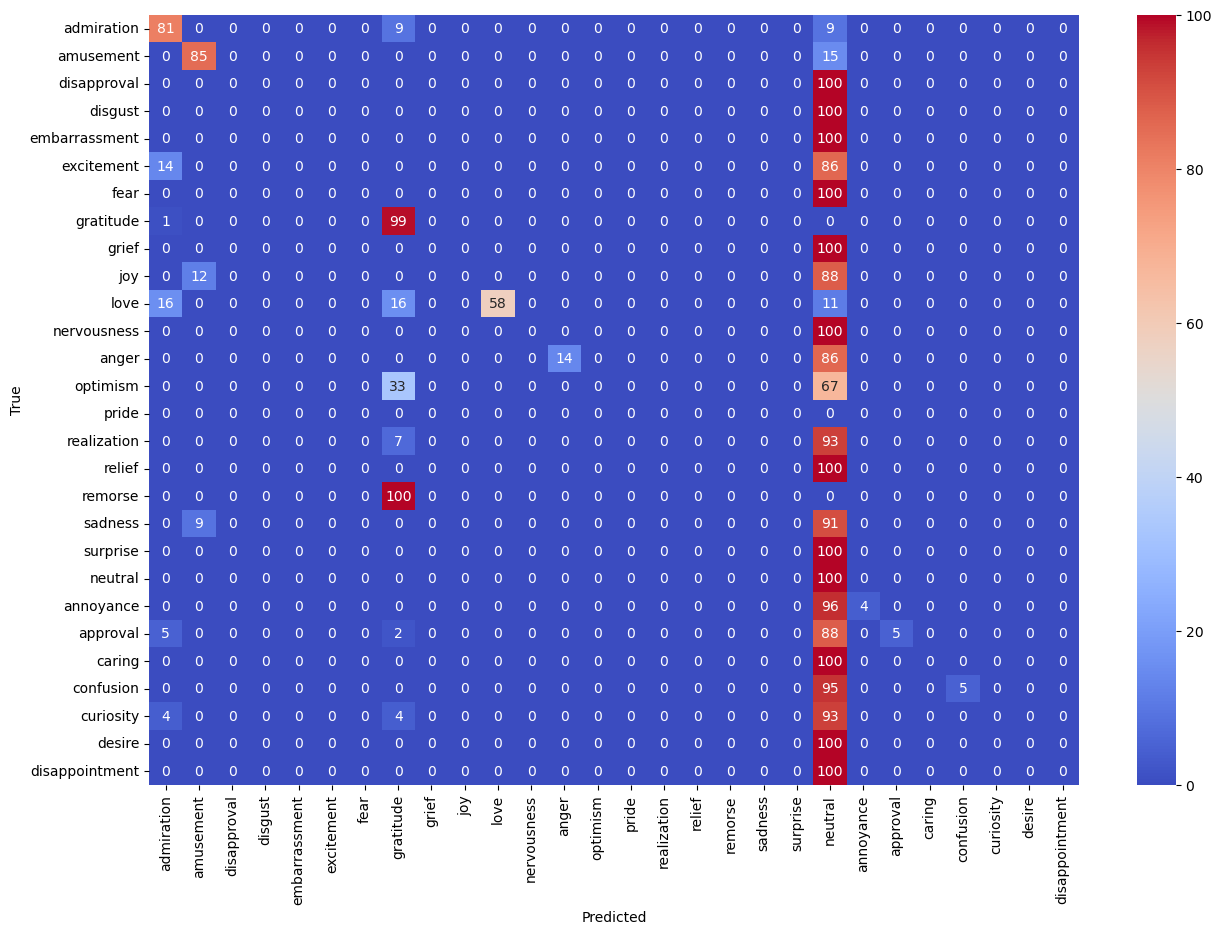

Val confusion matrix


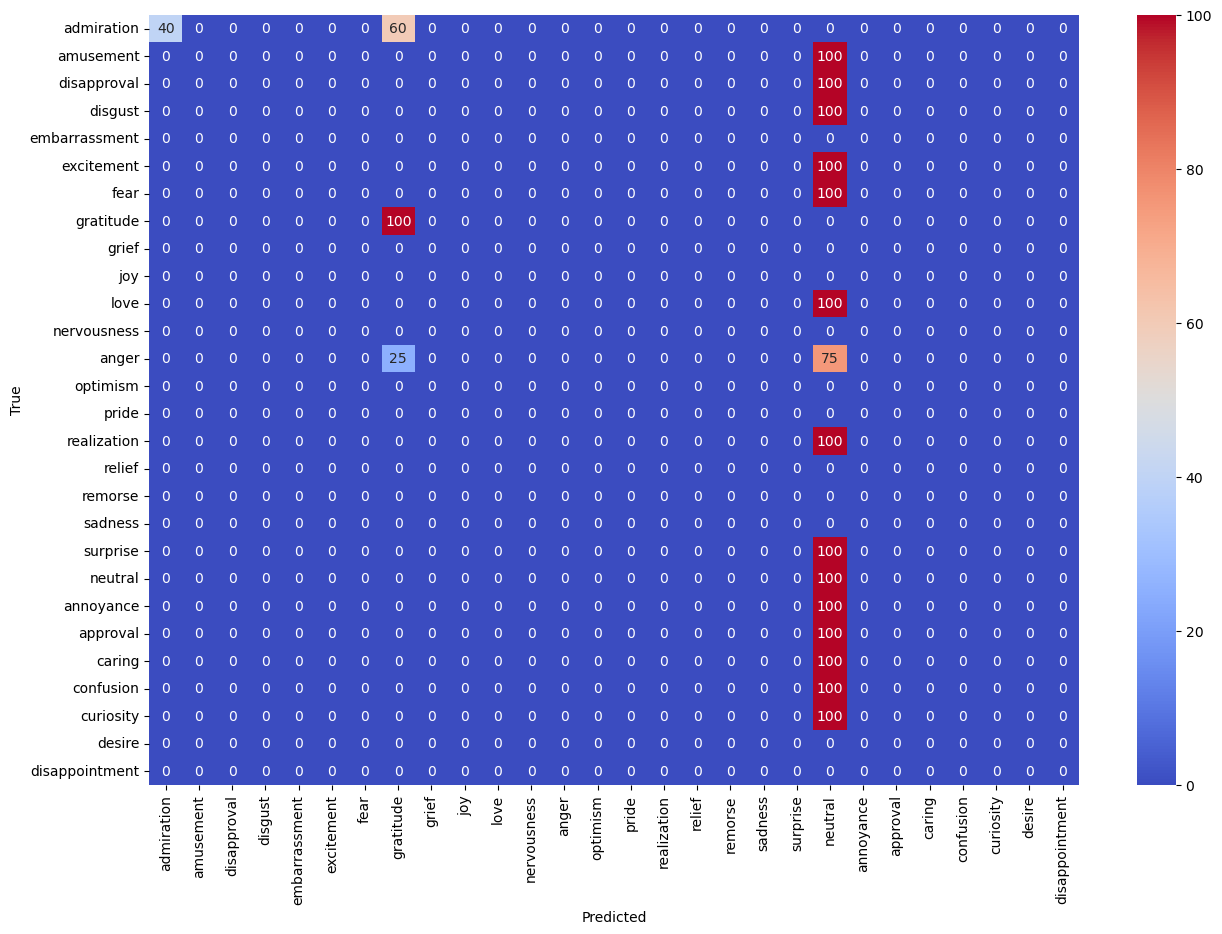

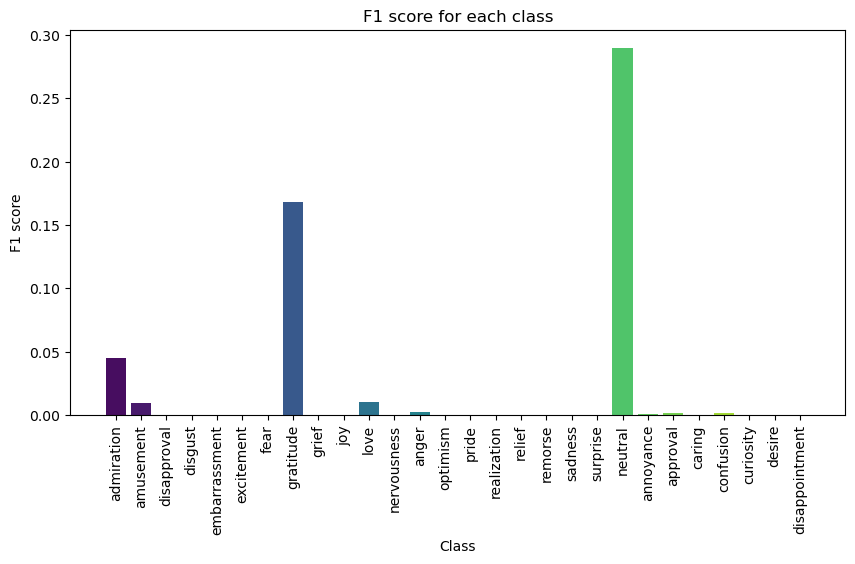

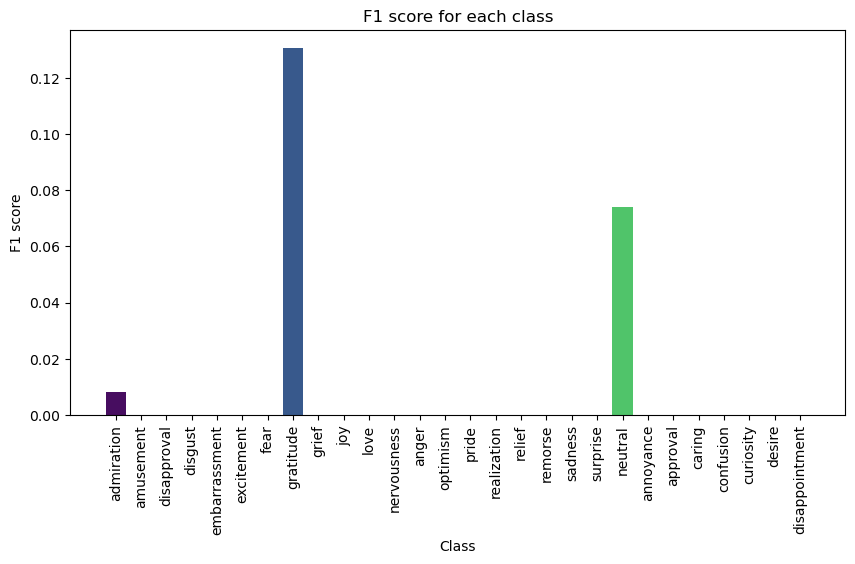

In [10]:
# training one versus rest classifier
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
]))

bayes_analysis(train_df, val_df, NB_classifier, TEXT_COLUMN, LABELS)

## Testing Bayes with normalized text

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.95                0.05                0.10                0.05                4130
amusement                           0.91                0.02                0.03                0.02                2328
disapproval                         0.00                0.00                0.00                0.00                2022
disgust                             1.00                0.01                0.02                0.01                 793
embarrassment                       0.00                0.00                0.00                0.00                 303
excitement                          0.00                0.00                0.00                0.00                 853
fear                                0.00                0.00                0.00                0.00                

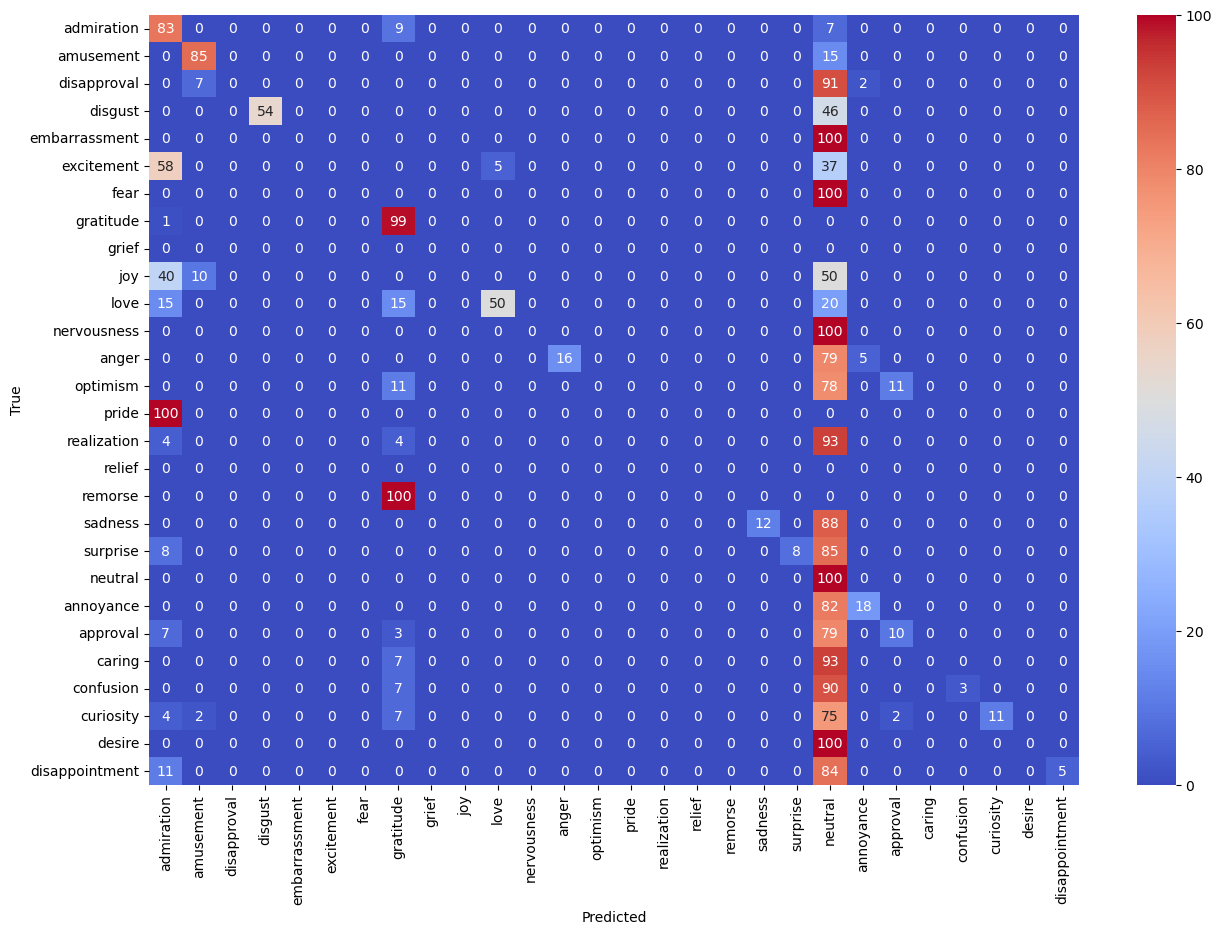

Val confusion matrix


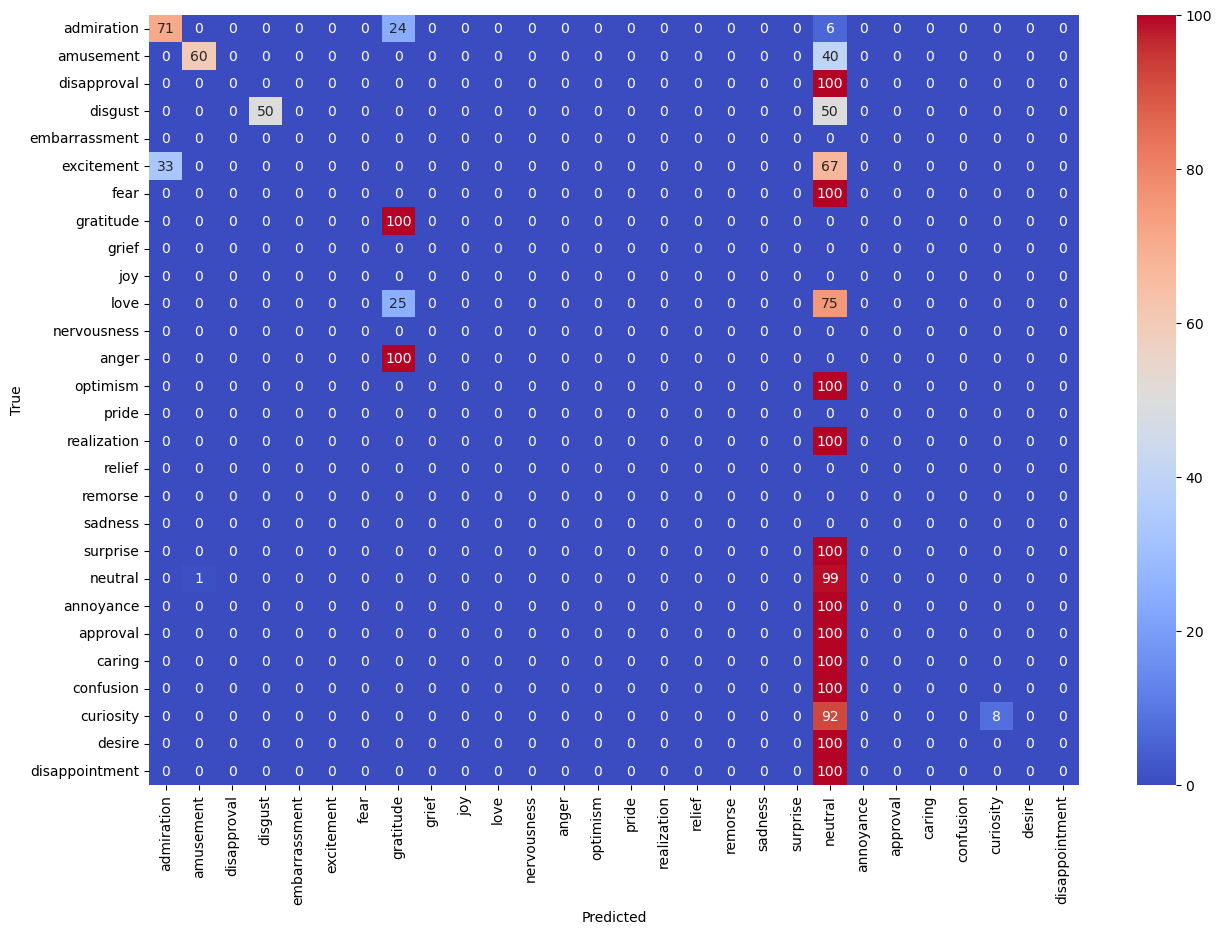

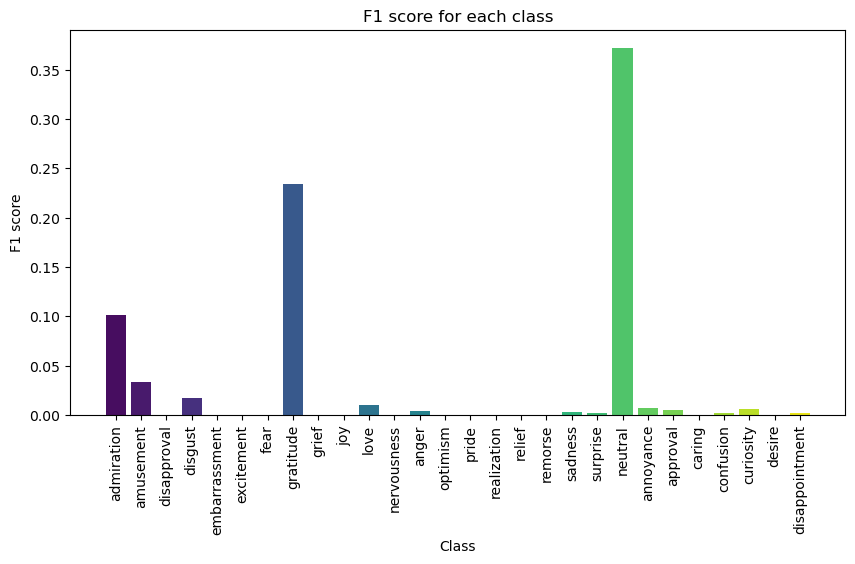

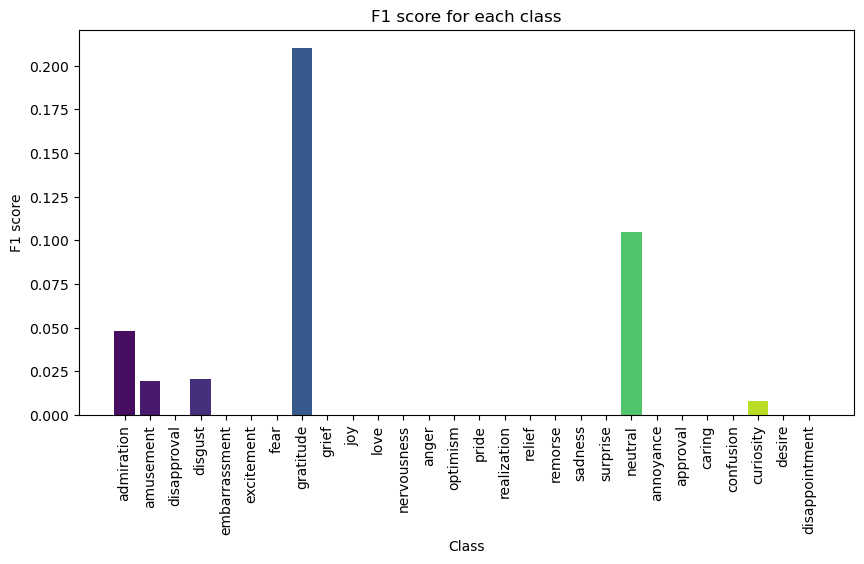

In [11]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', MultinomialNB())
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

## Test add k

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.97                0.36                0.53                0.36                4130
amusement                           0.97                0.27                0.43                0.27                2328
disapproval                         0.99                0.16                0.28                0.16                2022
disgust                             0.98                0.16                0.28                0.16                 793
embarrassment                       1.00                0.09                0.16                0.09                 303
excitement                          0.99                0.15                0.27                0.15                 853
fear                                1.00                0.13                0.24                0.13                

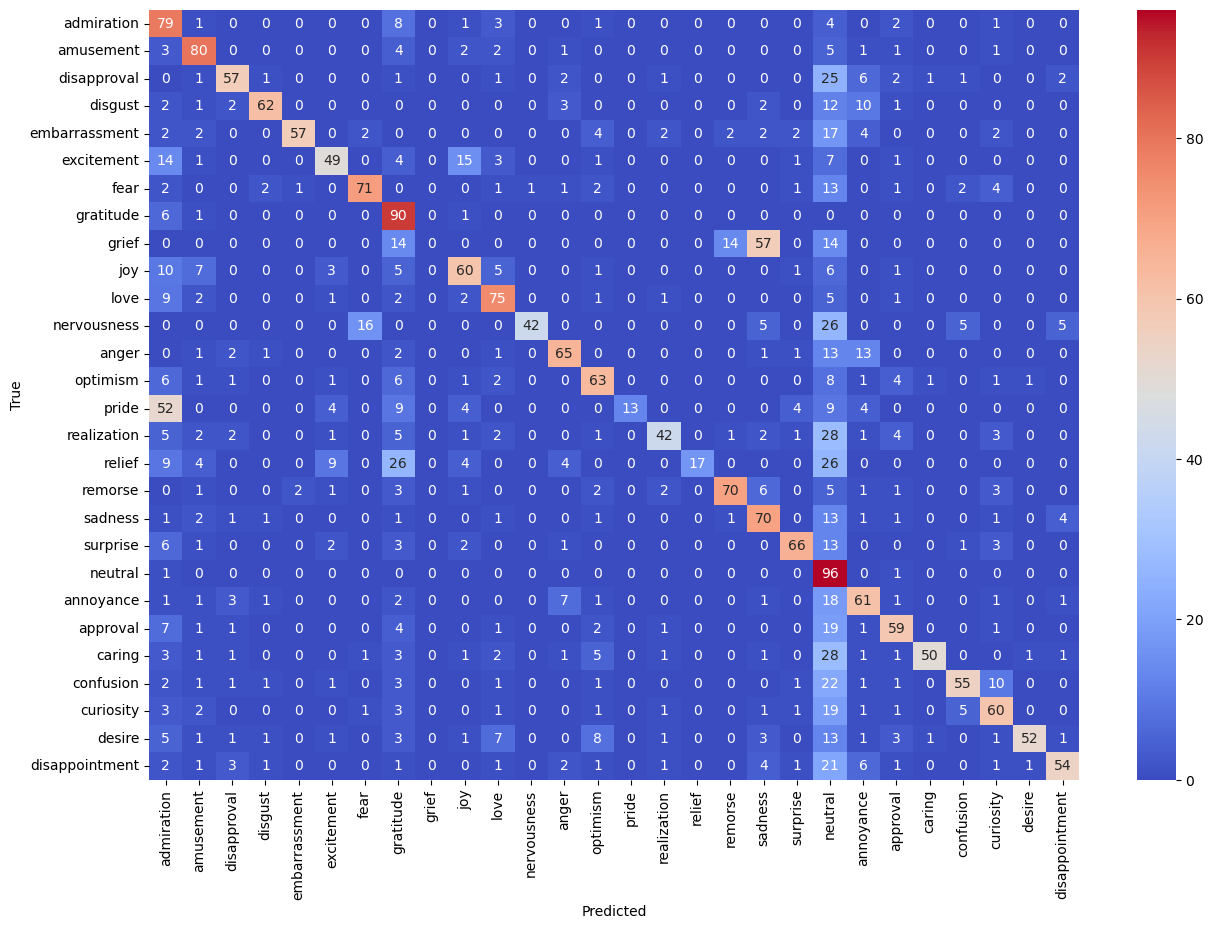

Val confusion matrix


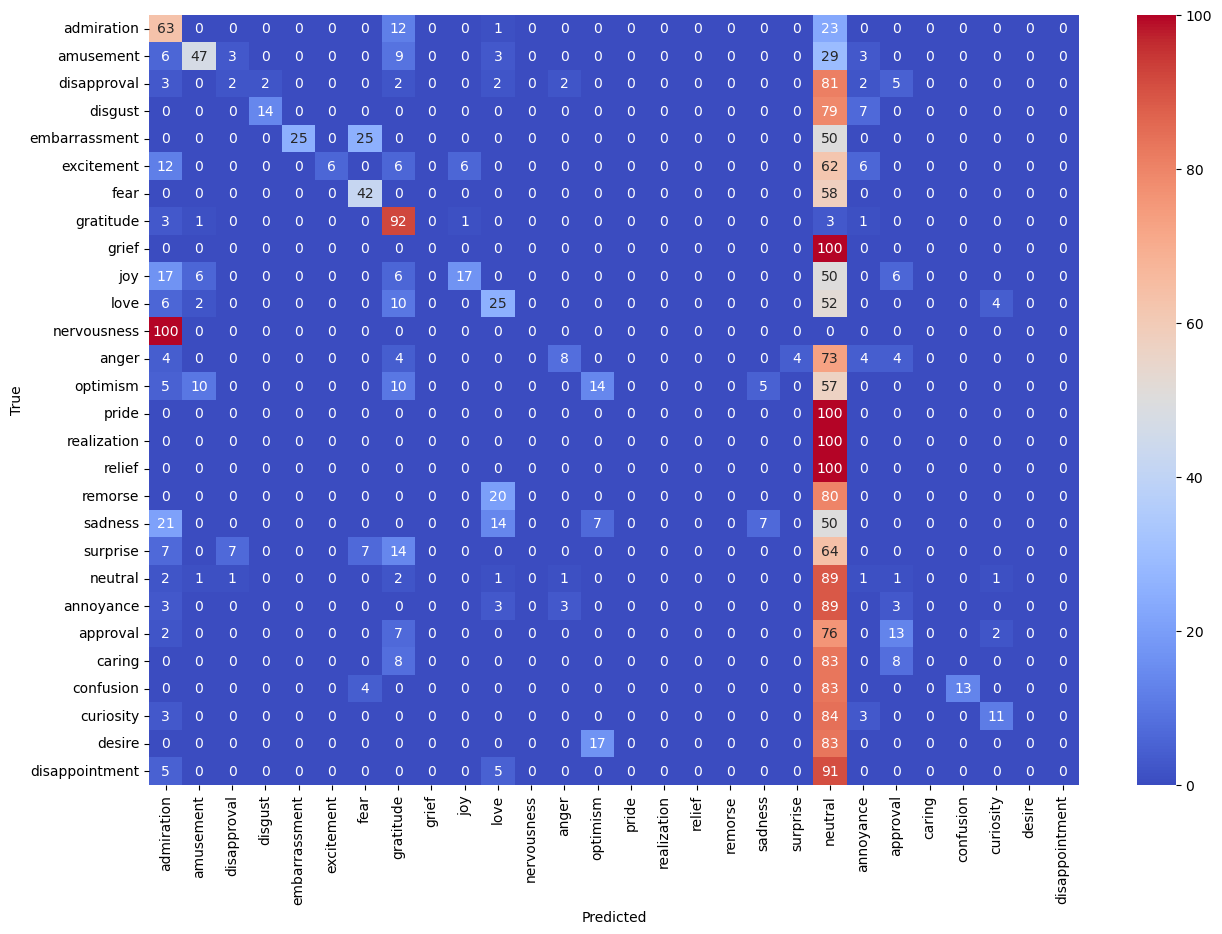

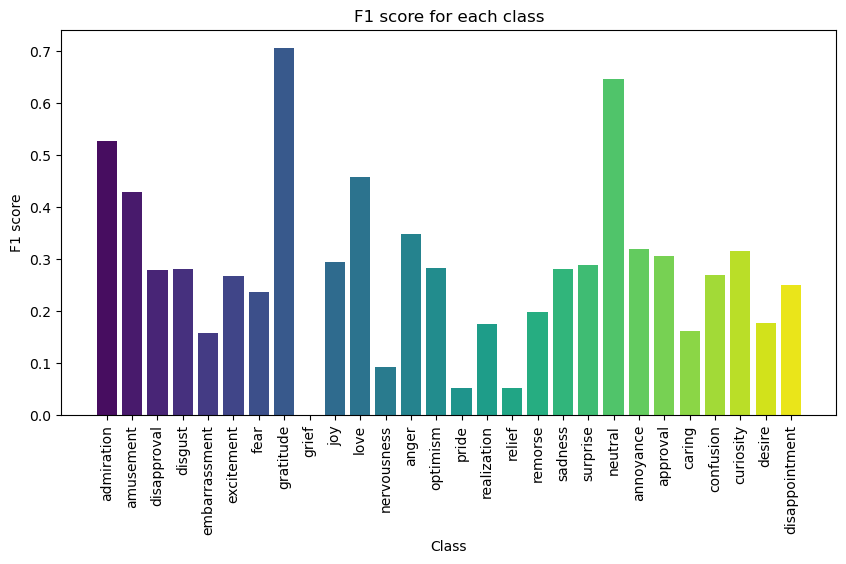

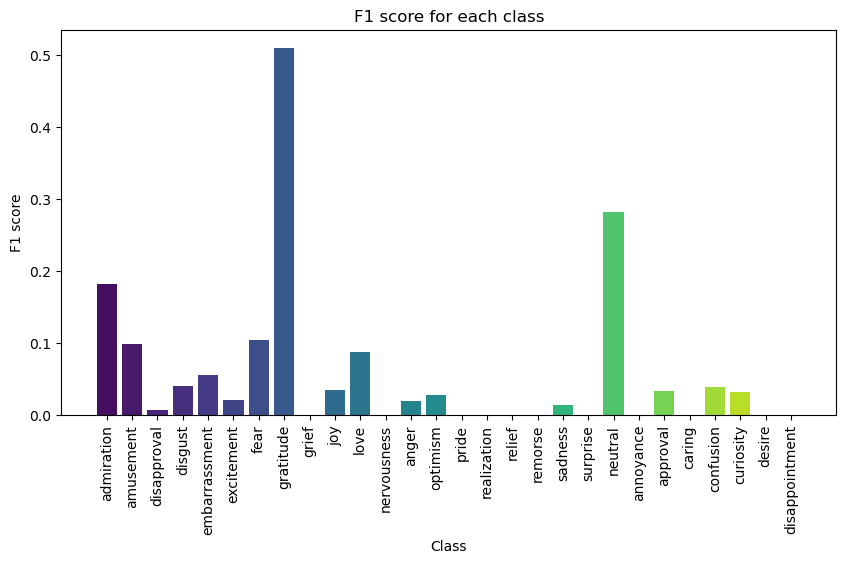

In [12]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB(alpha=0.1))
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Add one smoothing is too much, decreasing it offered an improvement of performances

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.84                0.74                0.79                0.65                4130
amusement                           0.89                0.87                0.88                0.79                2328
disapproval                         0.79                0.52                0.63                0.46                2022
disgust                             0.89                0.70                0.78                0.65                 793
embarrassment                       0.90                0.76                0.82                0.70                 303
excitement                          0.74                0.65                0.69                0.53                 853
fear                                0.91                0.80                0.85                0.74                

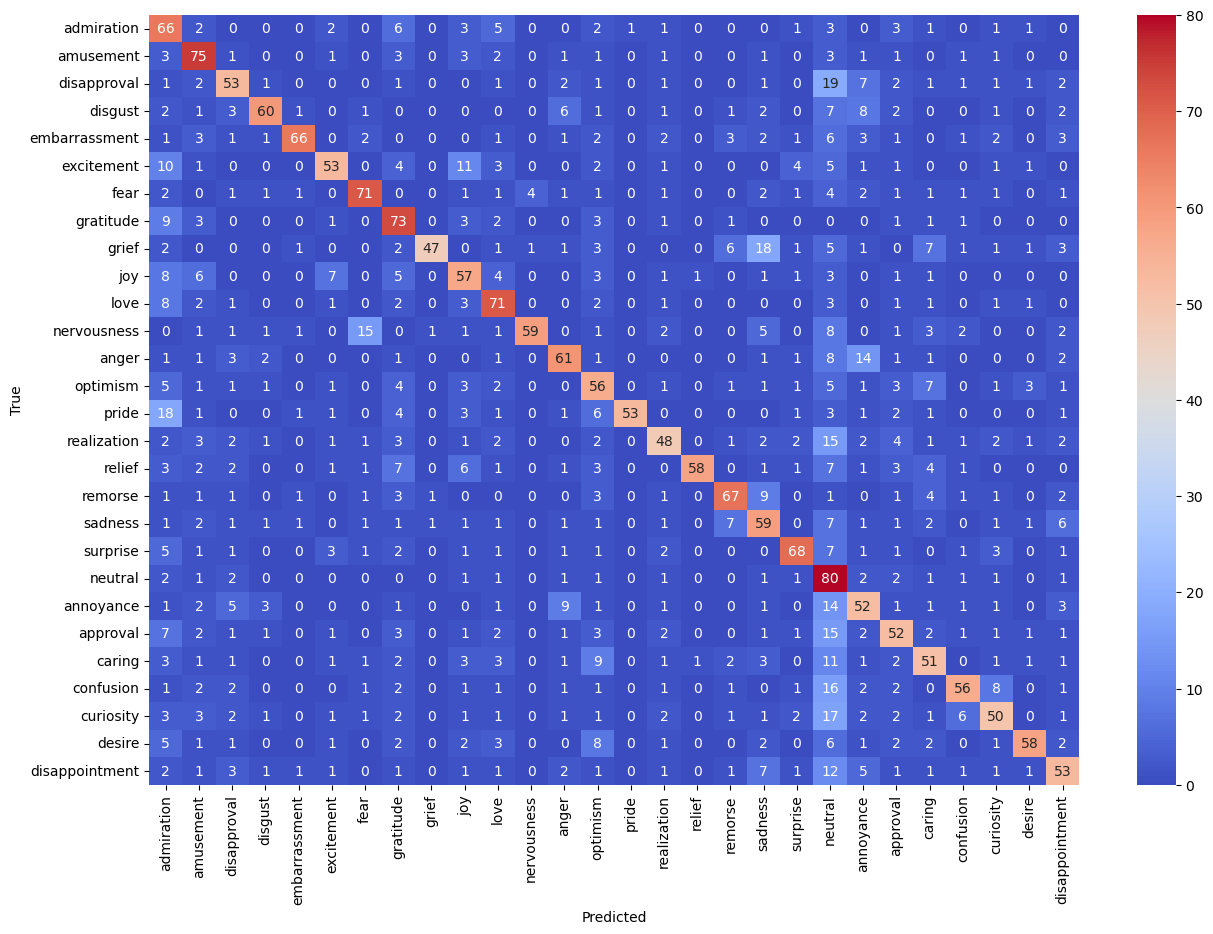

Val confusion matrix


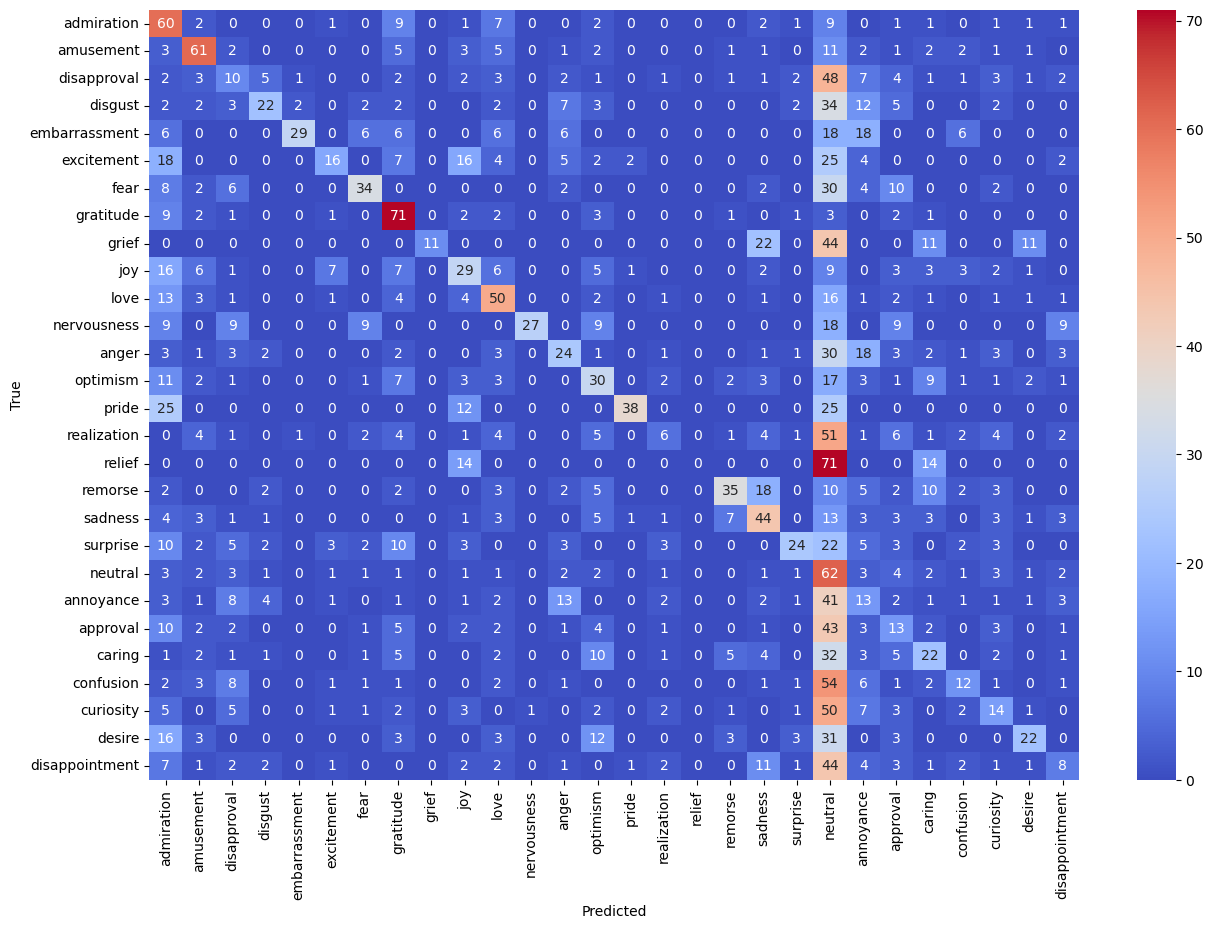

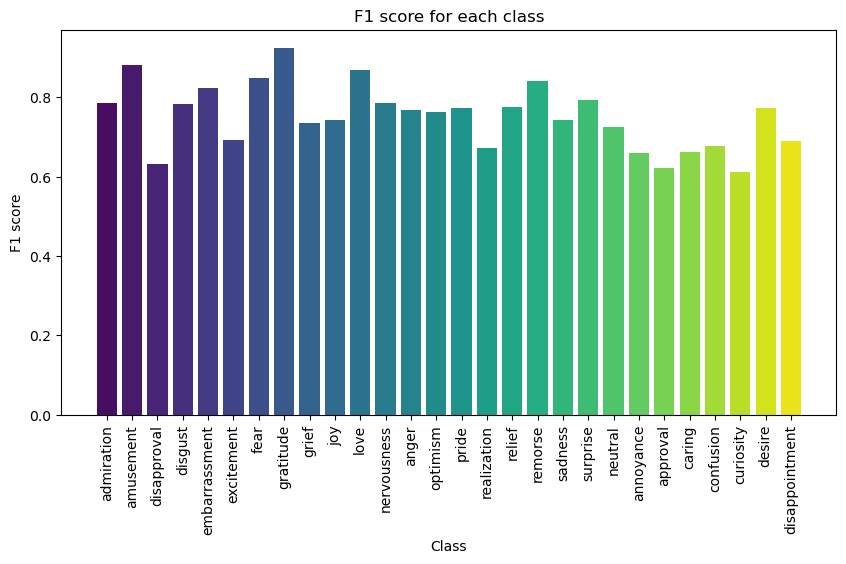

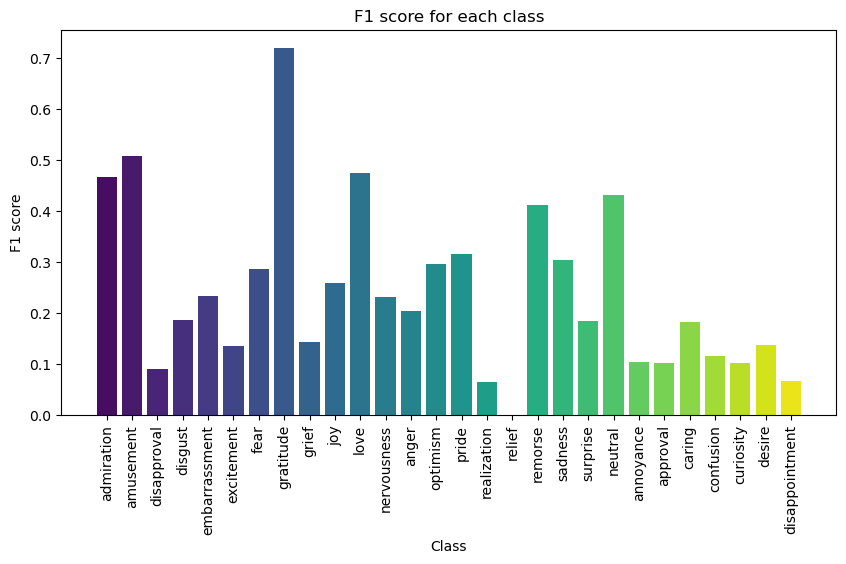

In [13]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', BernoulliNB(alpha=0.01))
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.84                0.74                0.79                0.65                4130
amusement                           0.89                0.87                0.88                0.79                2328
disapproval                         0.79                0.52                0.63                0.46                2022
disgust                             0.89                0.70                0.78                0.65                 793
embarrassment                       0.90                0.76                0.82                0.70                 303
excitement                          0.74                0.65                0.69                0.53                 853
fear                                0.91                0.80                0.85                0.74                

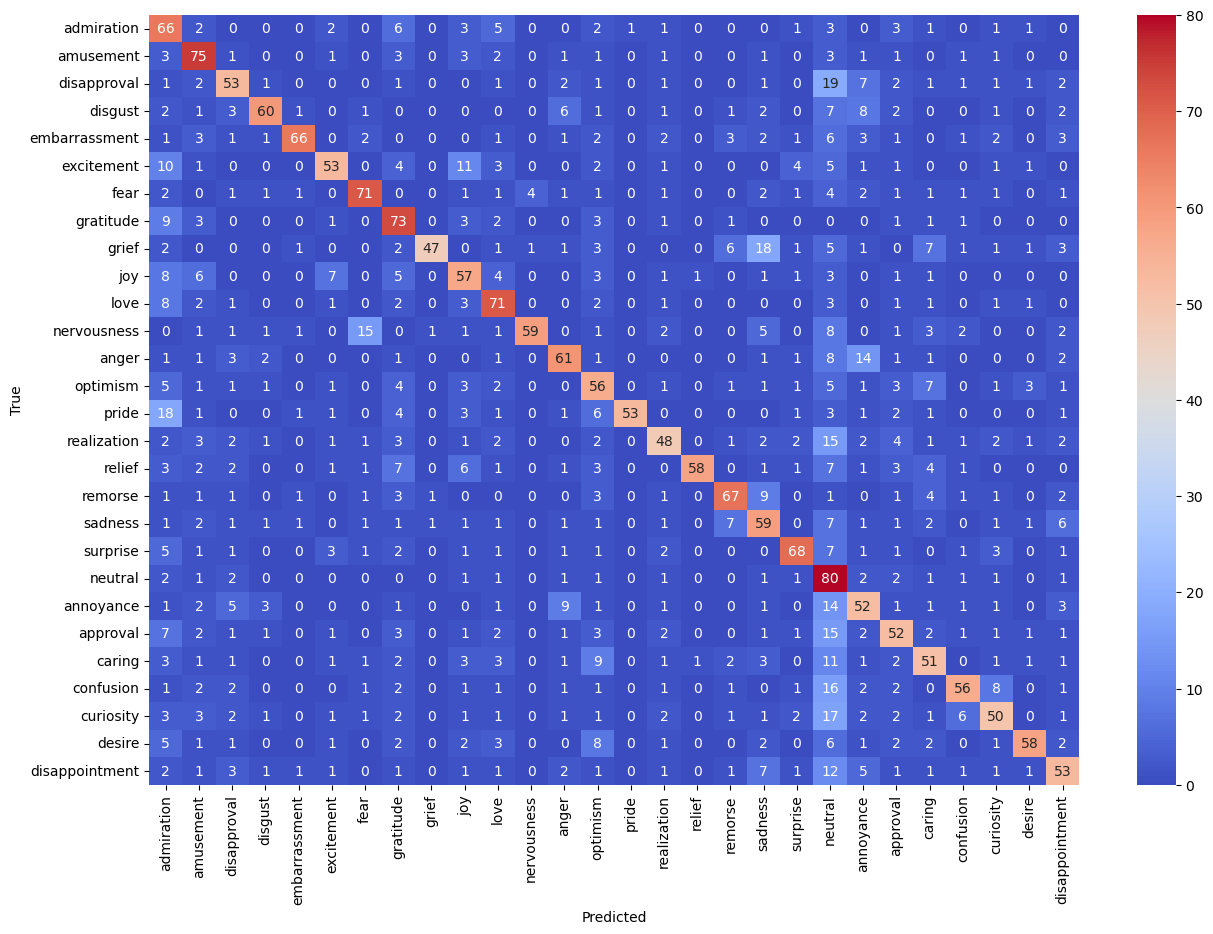

Val confusion matrix


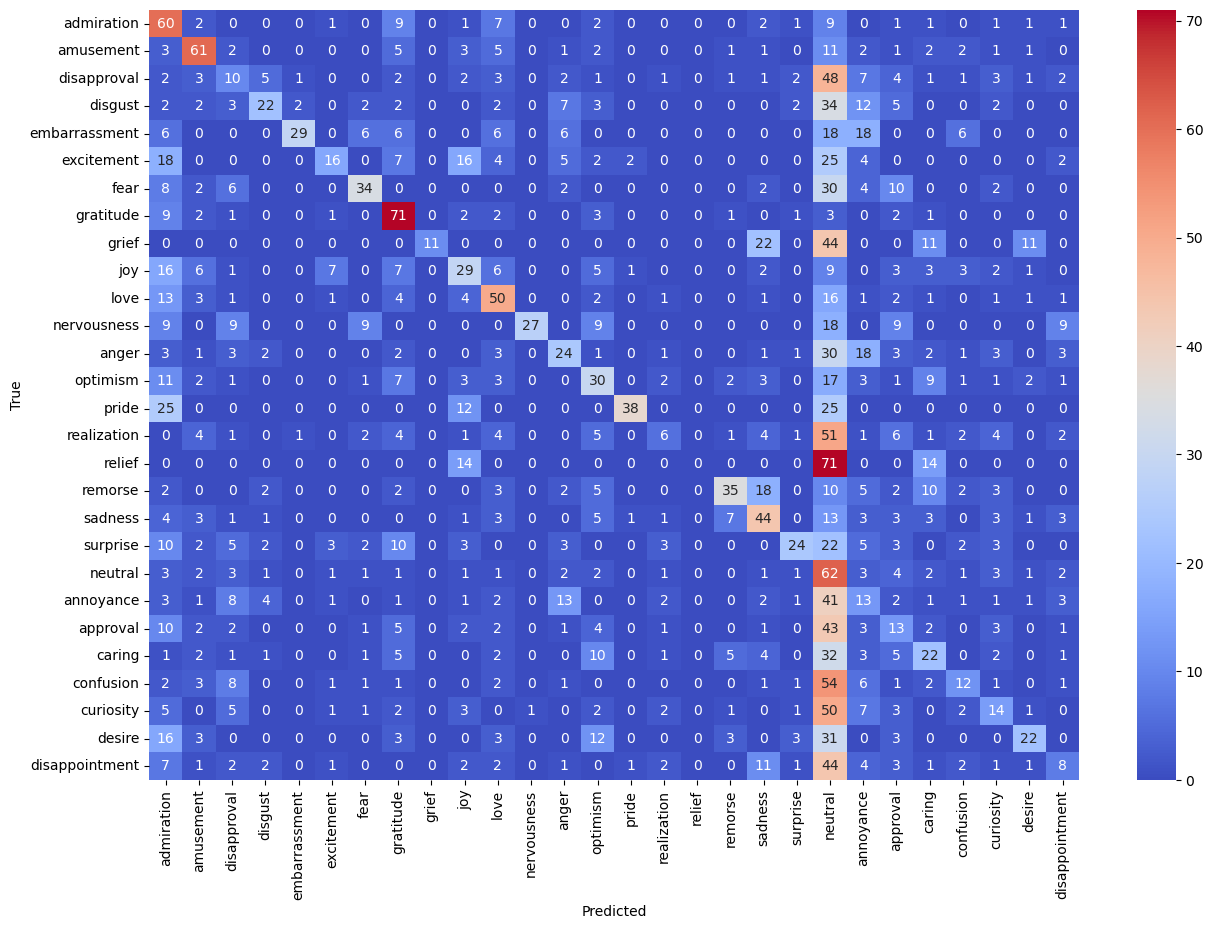

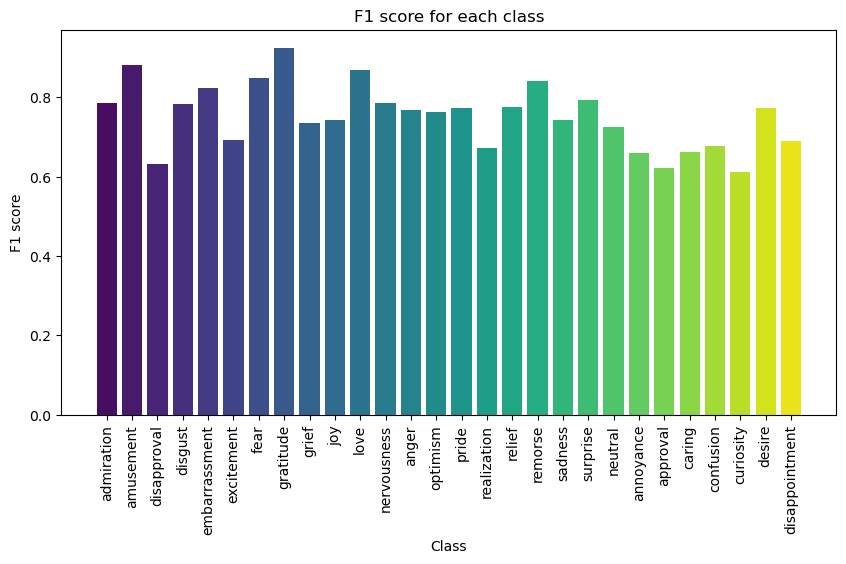

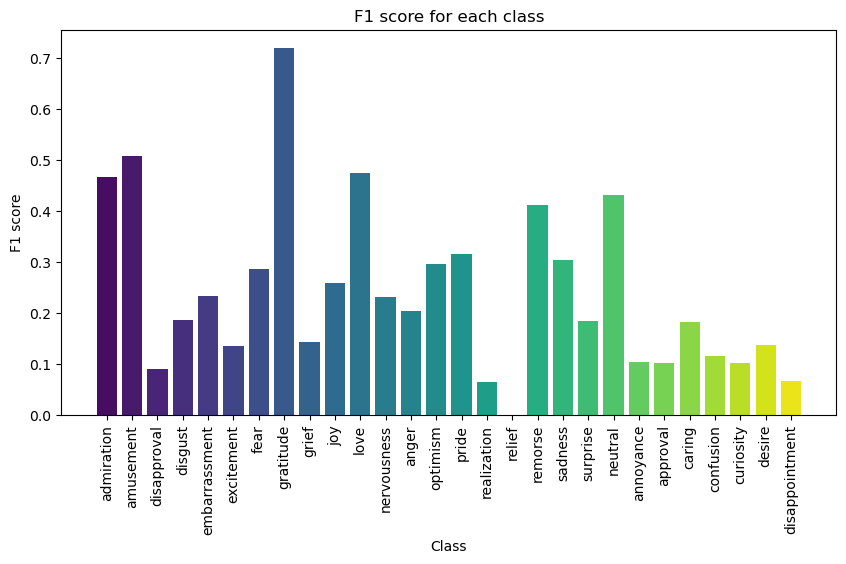

In [13]:
NB_classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', BernoulliNB(alpha=0.01))
]))
bayes_analysis(train_df, val_df, NB_classifier, CLEAN_TEXT_COLUMN, LABELS)

Removing stopwords does not improve the performances

## Feature selection

Attempt with min df

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.72                0.61                0.66                0.50                4130
amusement                           0.84                0.74                0.79                0.65                2328
disapproval                         0.46                0.30                0.36                0.22                2022
disgust                             0.74                0.52                0.61                0.44                 793
embarrassment                       0.82                0.65                0.73                0.57                 303
excitement                          0.56                0.47                0.51                0.34                 853
fear                                0.82                0.66                0.73                0.58                

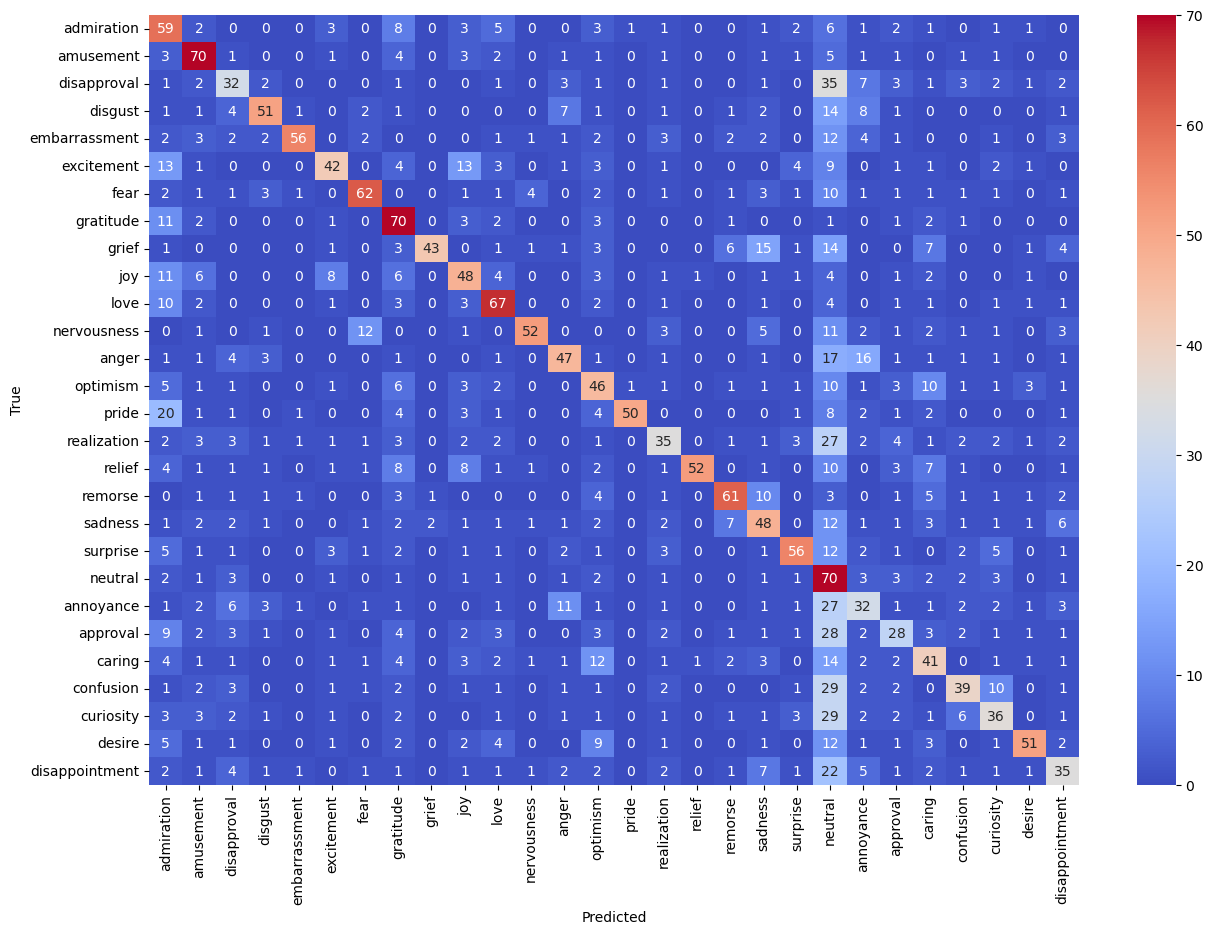

Val confusion matrix


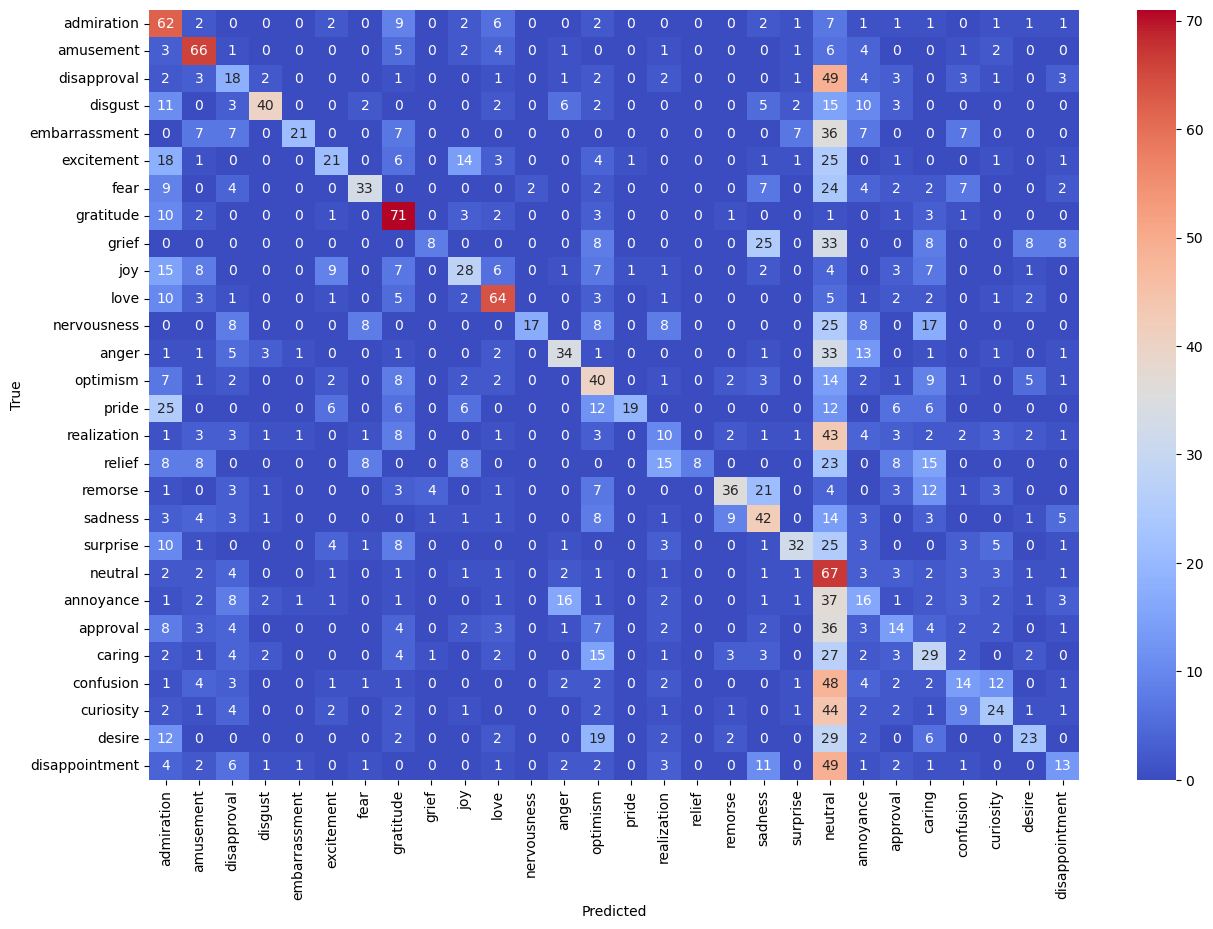

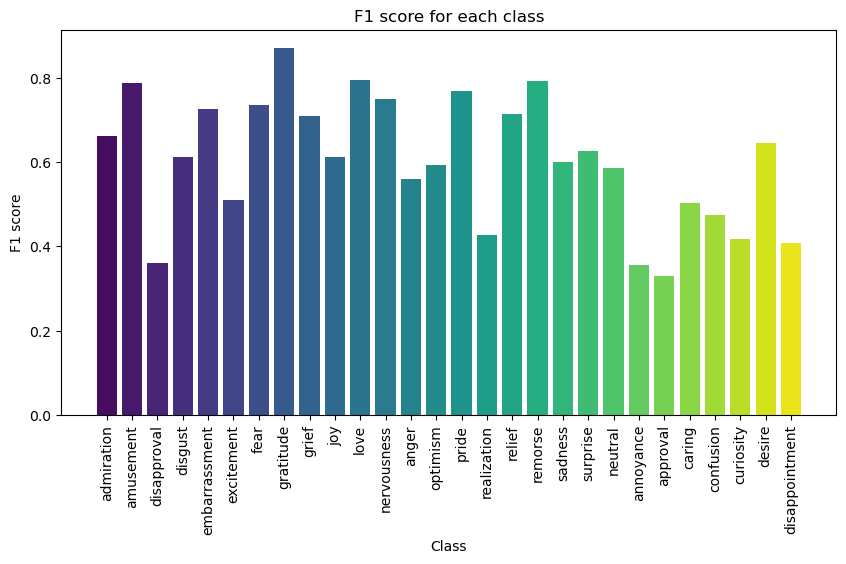

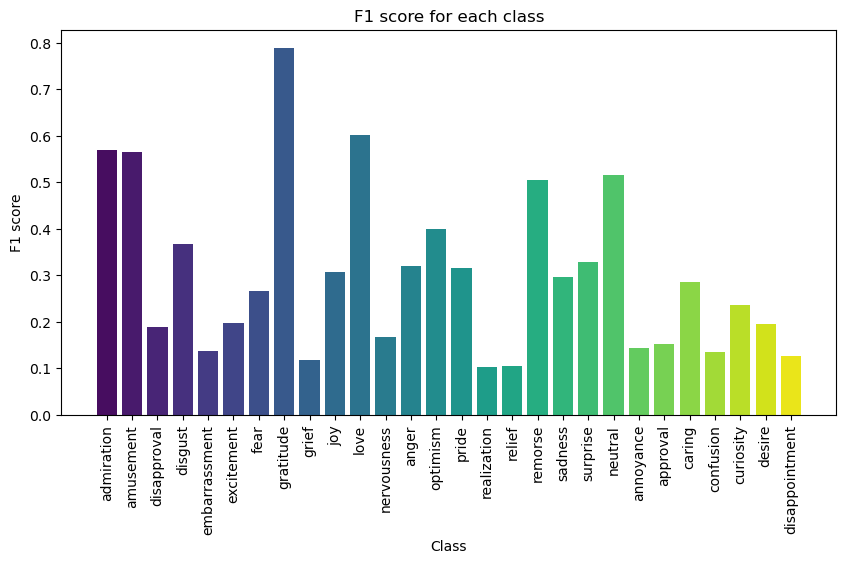

In [15]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('tfidf', TfidfVectorizer(min_df=10)),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Attempt also with pmi based feature selection

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.75                0.57                0.65                0.48                4130
amusement                           0.84                0.71                0.77                0.63                2328
disapproval                         0.44                0.25                0.32                0.19                2022
disgust                             0.71                0.44                0.55                0.38                 793
embarrassment                       0.78                0.58                0.67                0.50                 303
excitement                          0.57                0.39                0.46                0.30                 853
fear                                0.79                0.61                0.69                0.52                

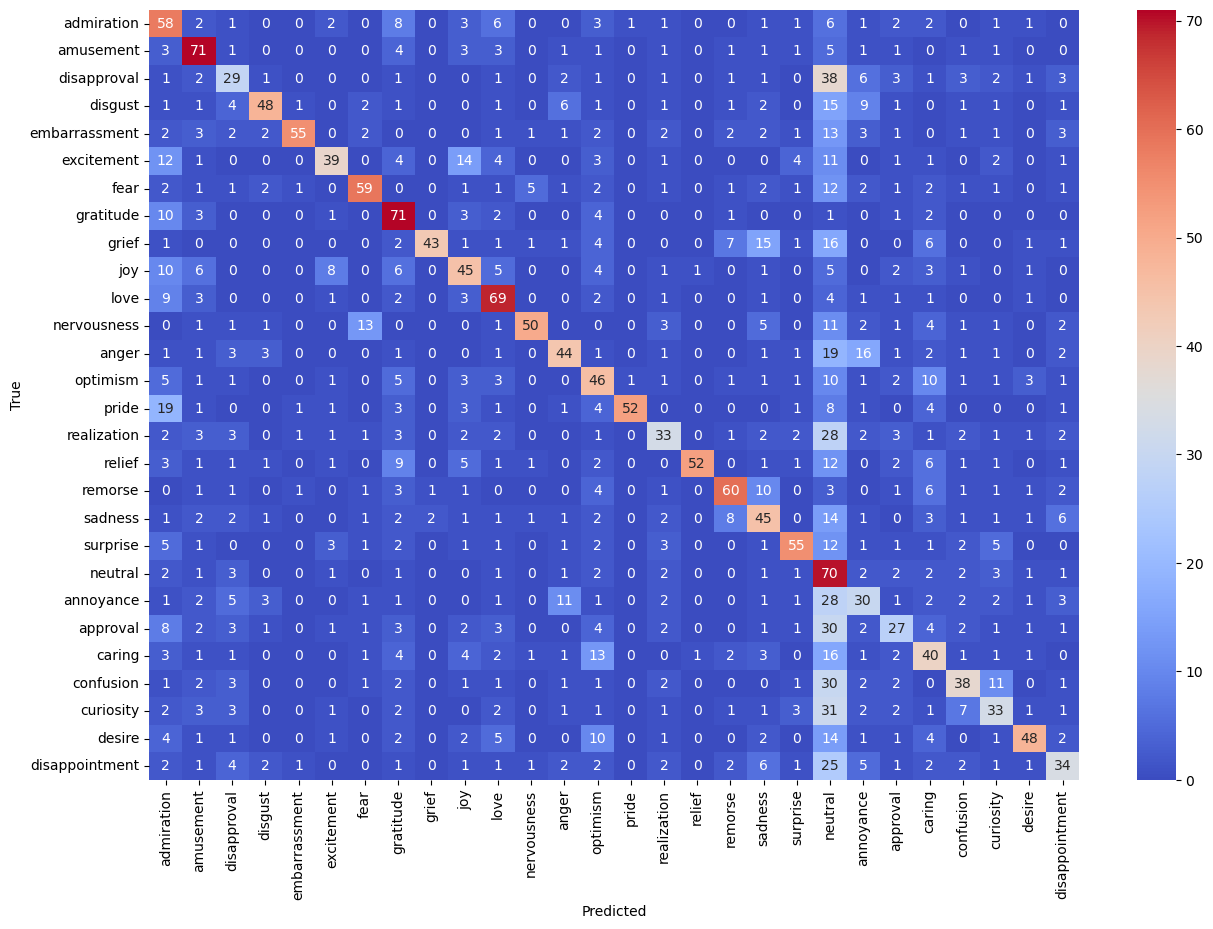

Val confusion matrix


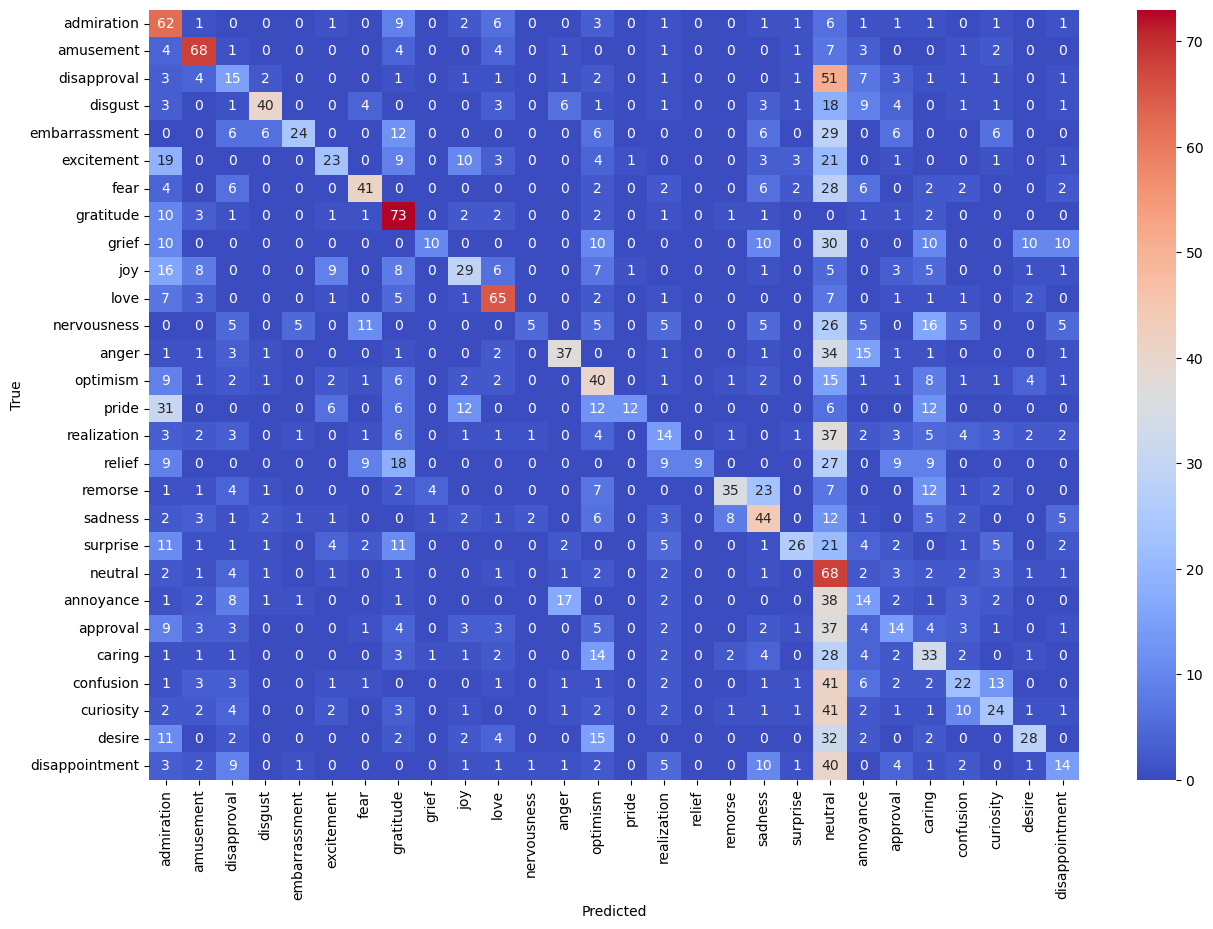

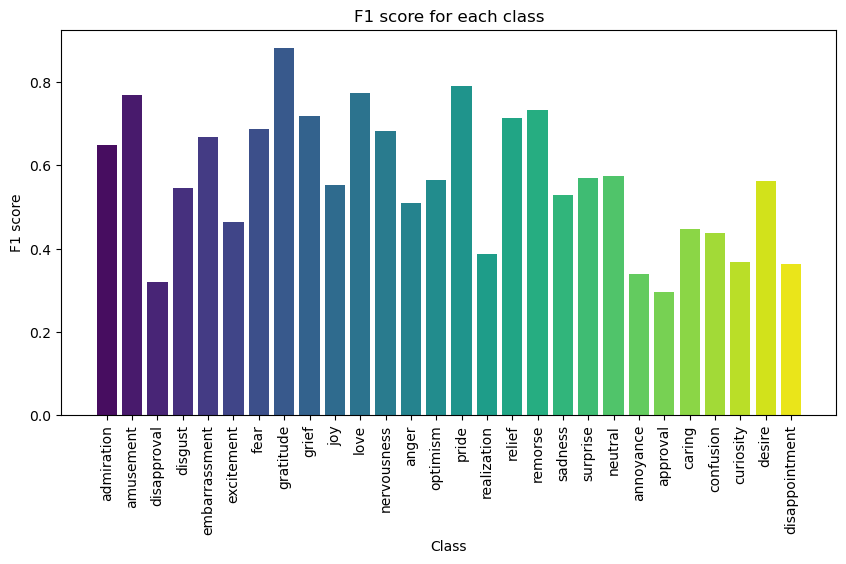

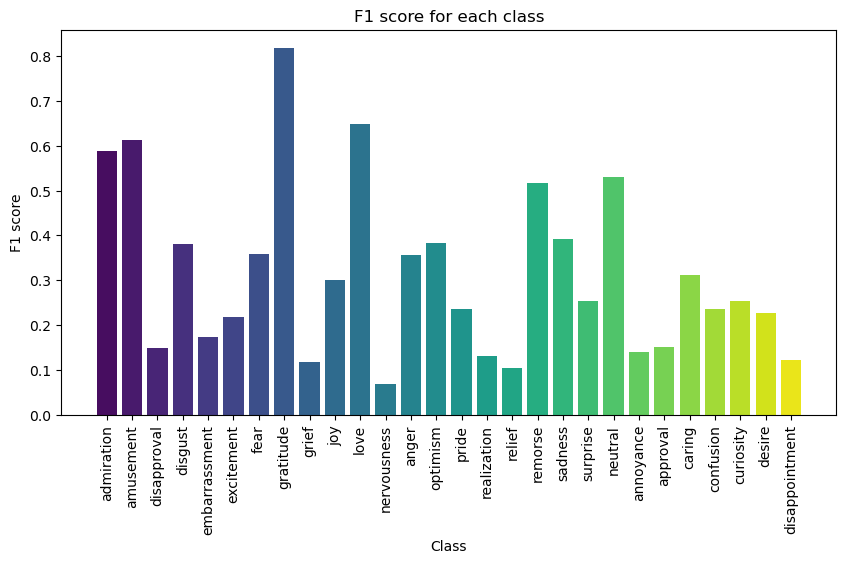

In [16]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.81                0.63                0.71                0.55                4130
amusement                           0.88                0.76                0.82                0.69                2328
disapproval                         0.65                0.44                0.52                0.36                2022
disgust                             0.81                0.63                0.70                0.54                 793
embarrassment                       0.89                0.74                0.81                0.68                 303
excitement                          0.70                0.59                0.64                0.47                 853
fear                                0.86                0.70                0.77                0.63                

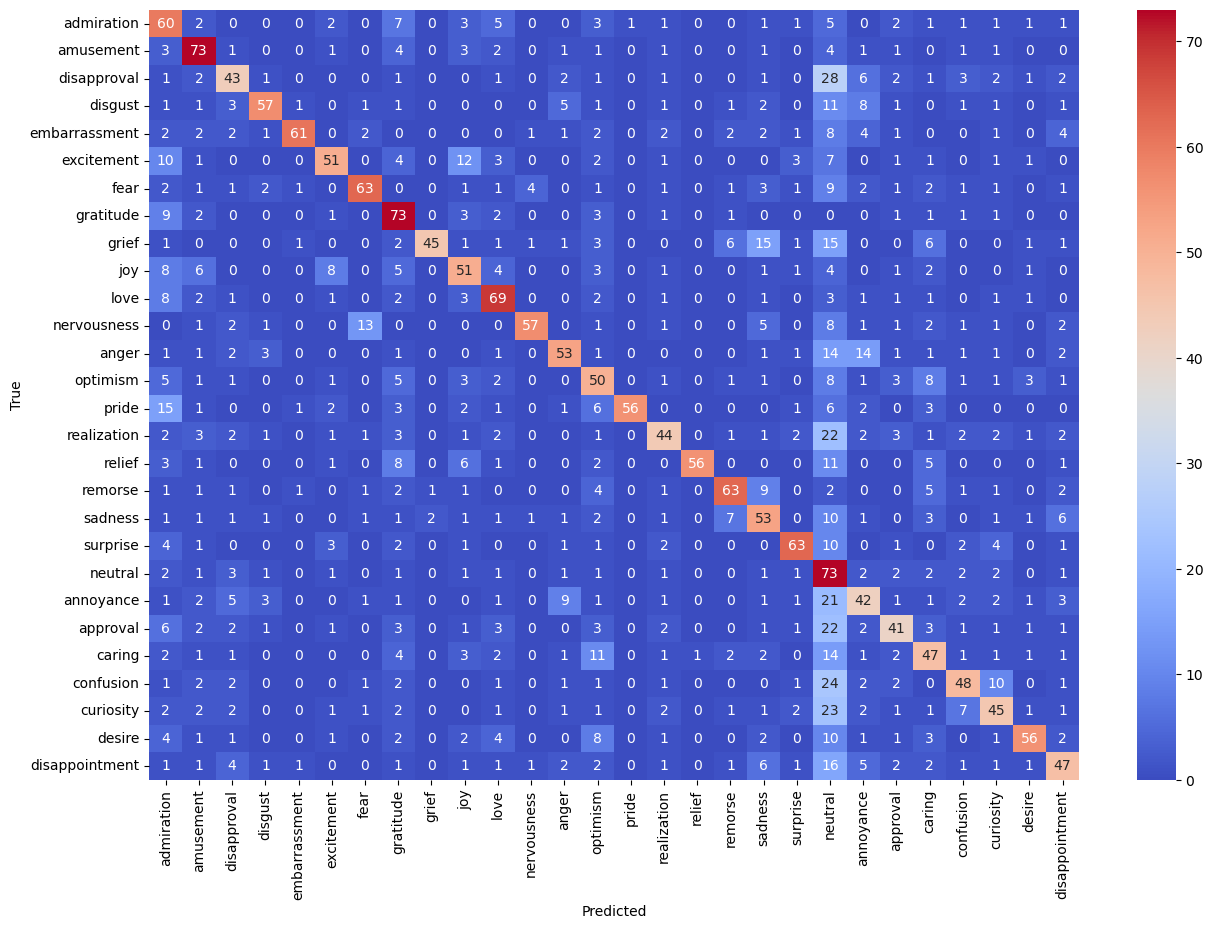

Val confusion matrix


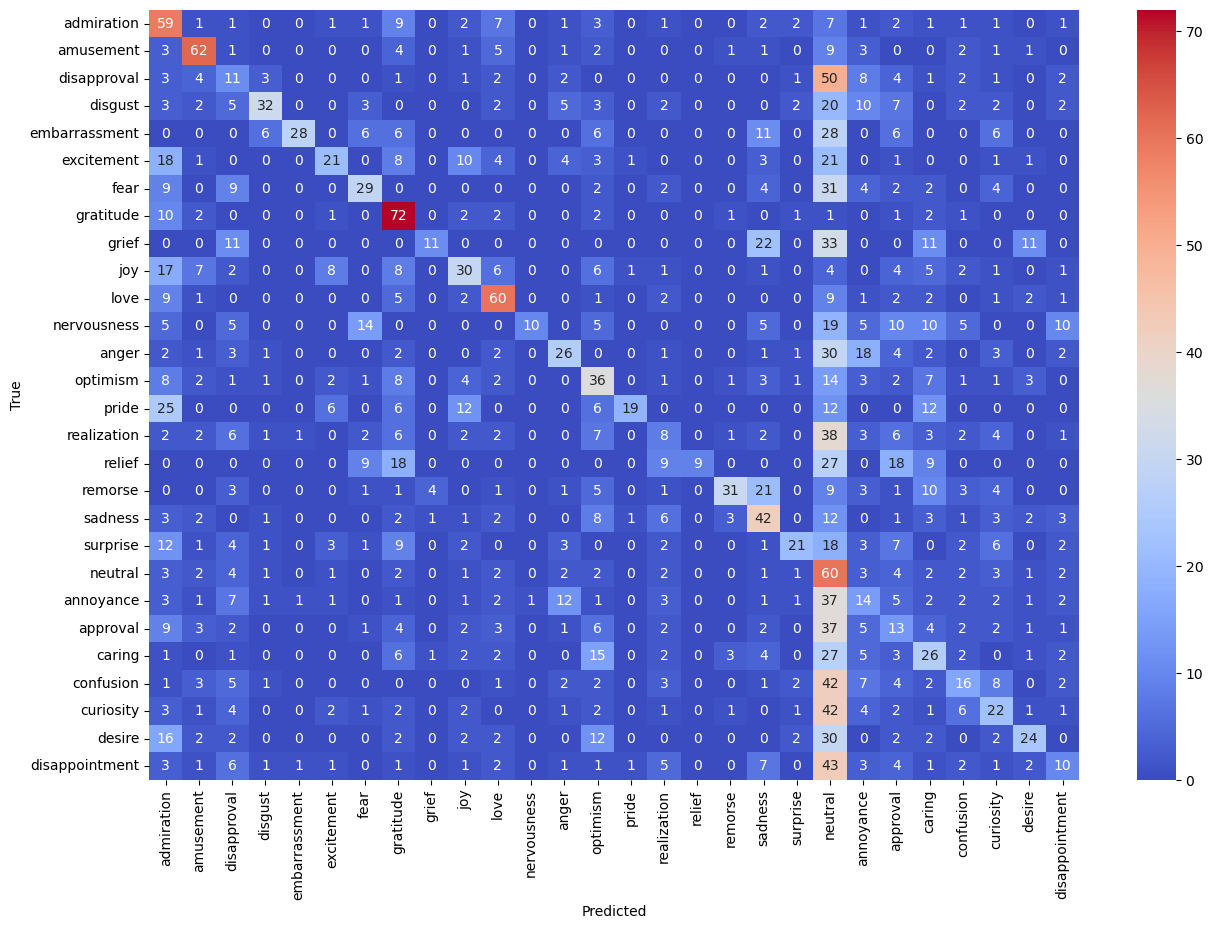

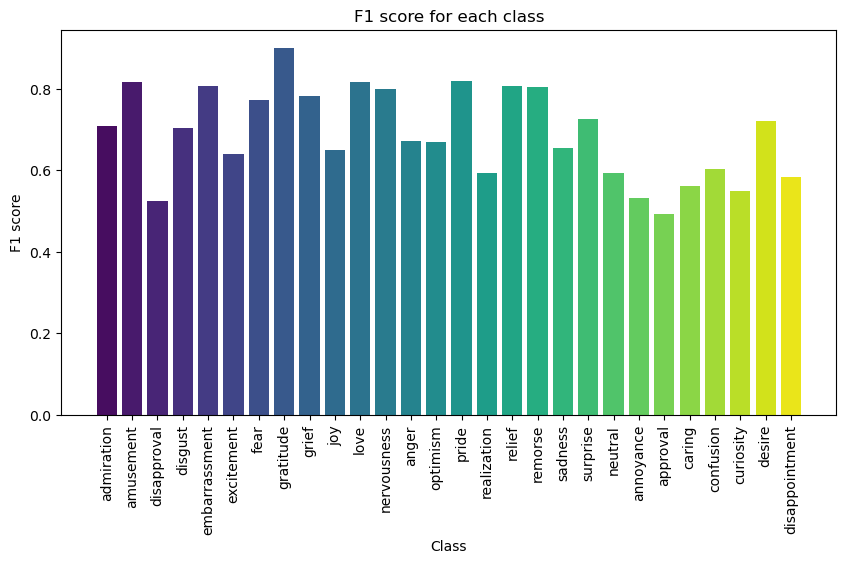

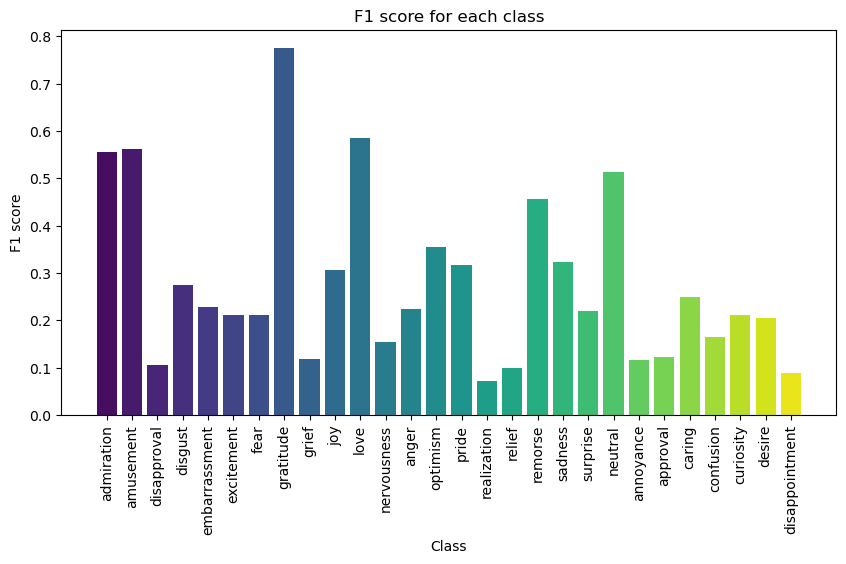

In [17]:
# training one versus rest classifier
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer()),
    ('select', SelectKBest(mutual_info_classif, k=2000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, CLEAN_TEXT_COLUMN, LABELS)

## Trying best on raw data to check for cleaning usefulness

In [18]:
# load raw dataset
raw_train_df, raw_val_df, raw_test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.75                0.59                0.66                0.49                4130
amusement                           0.84                0.71                0.77                0.62                2328
disapproval                         0.45                0.27                0.34                0.20                2022
disgust                             0.70                0.48                0.57                0.40                 793
embarrassment                       0.75                0.62                0.68                0.51                 303
excitement                          0.58                0.42                0.49                0.32                 853
fear                                0.77                0.59                0.67                0.50                

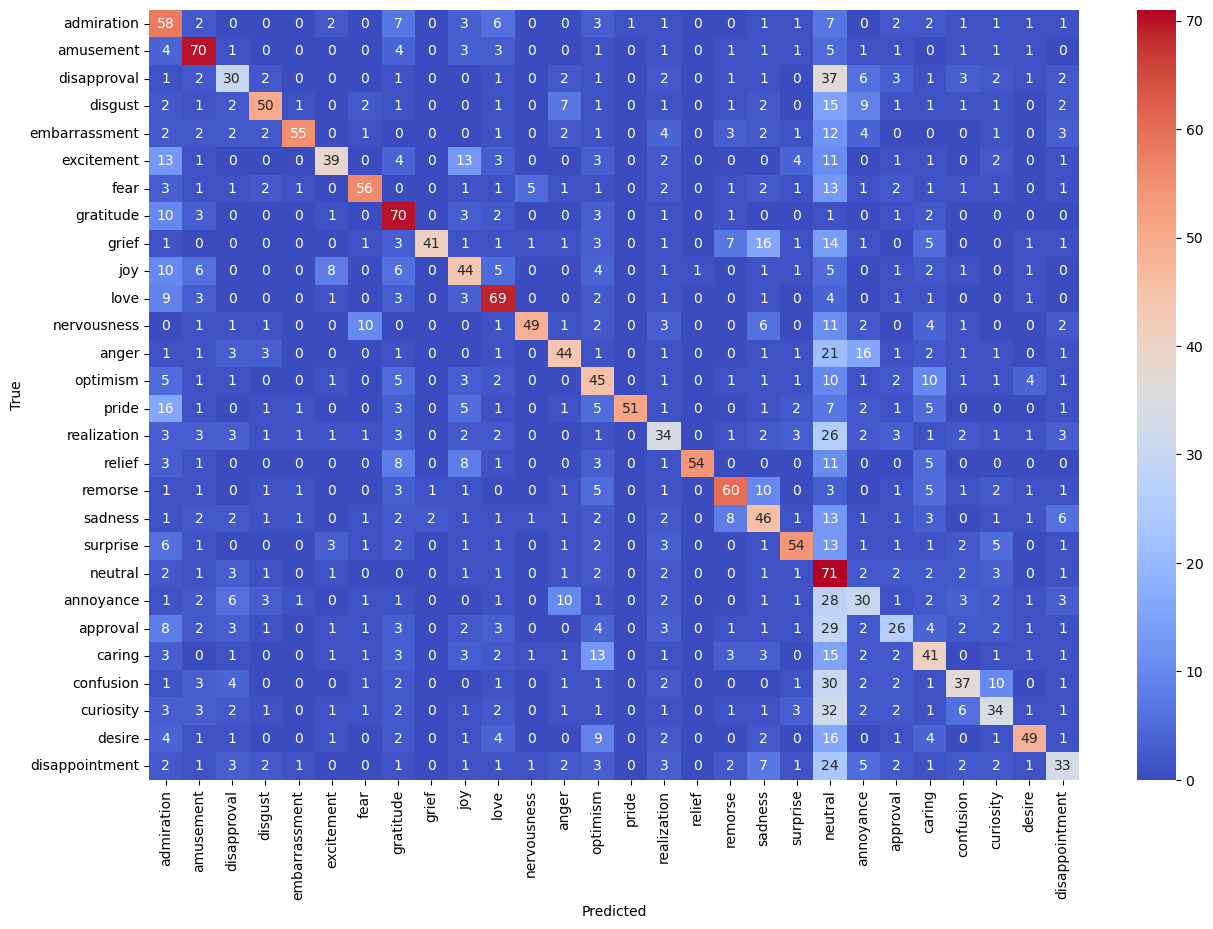

Val confusion matrix


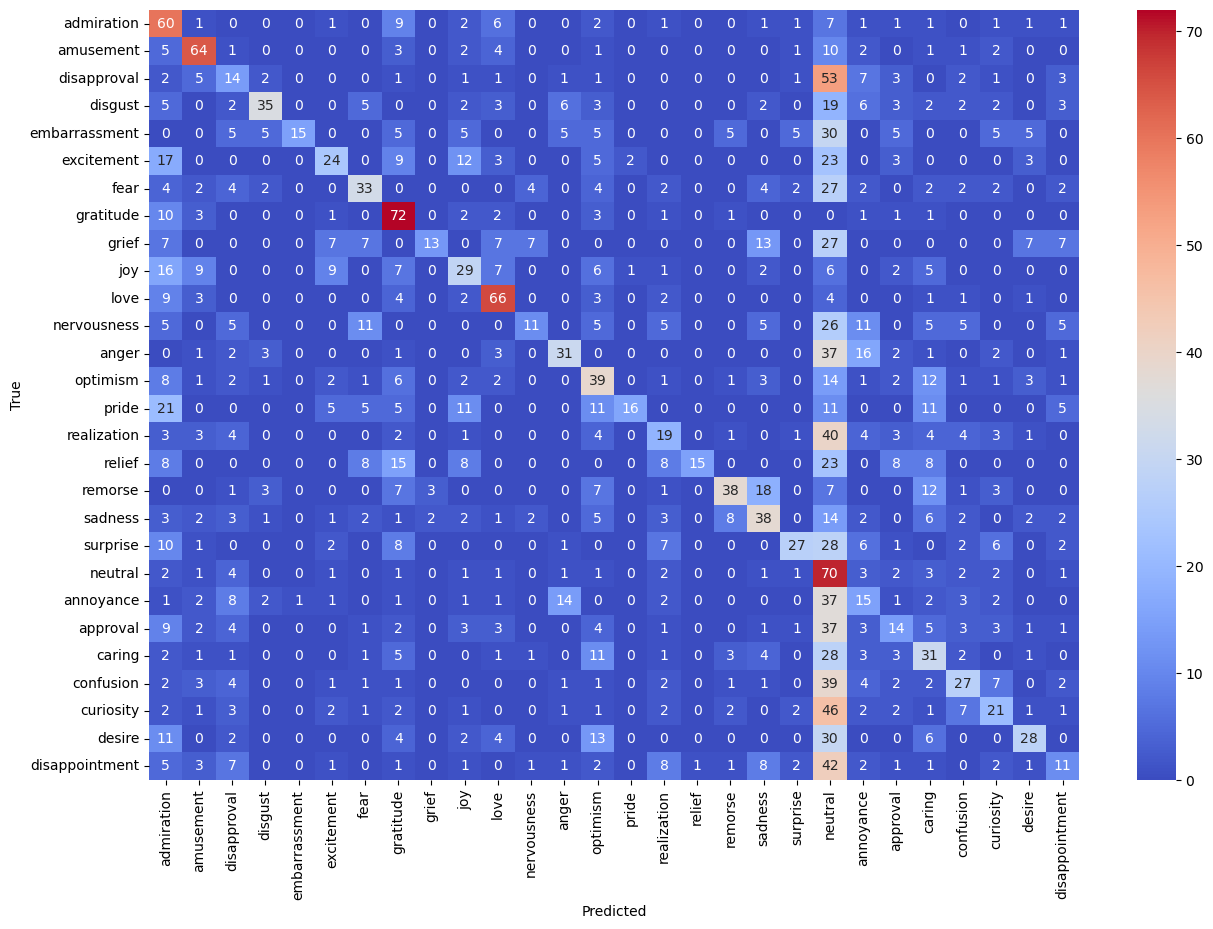

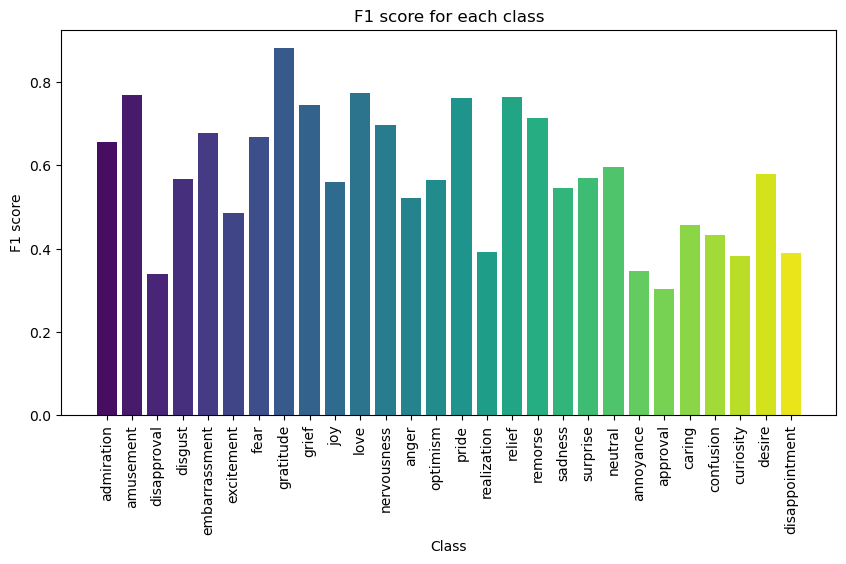

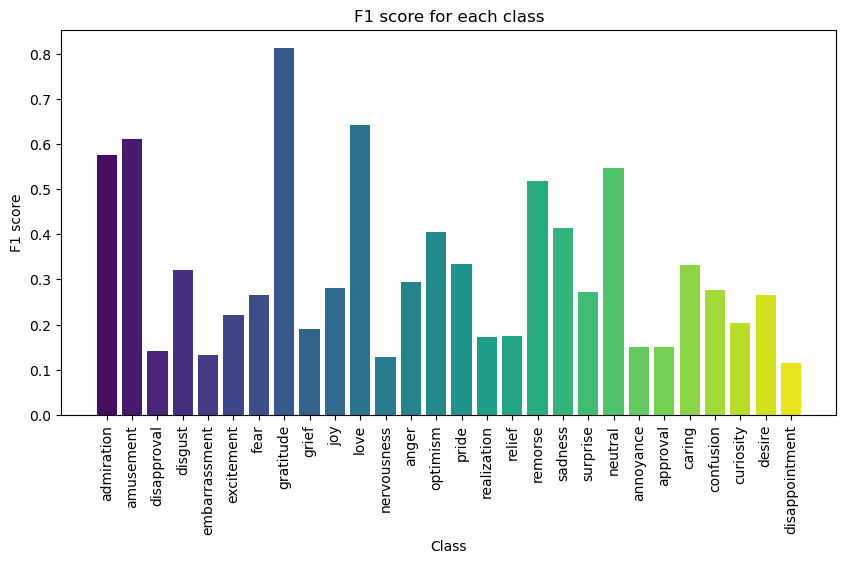

In [19]:
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(raw_train_df, raw_val_df, classifier, TEXT_COLUMN, LABELS)

In [14]:
train_df, val_df, test_df = load_dataset(DATASET)

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.75                0.59                0.66                0.49                4130
amusement                           0.84                0.71                0.77                0.63                2328
disapproval                         0.45                0.27                0.34                0.20                2022
disgust                             0.70                0.48                0.57                0.39                 793
embarrassment                       0.75                0.62                0.68                0.51                 303
excitement                          0.58                0.41                0.48                0.32                 853
fear                                0.77                0.59                0.67                0.50                

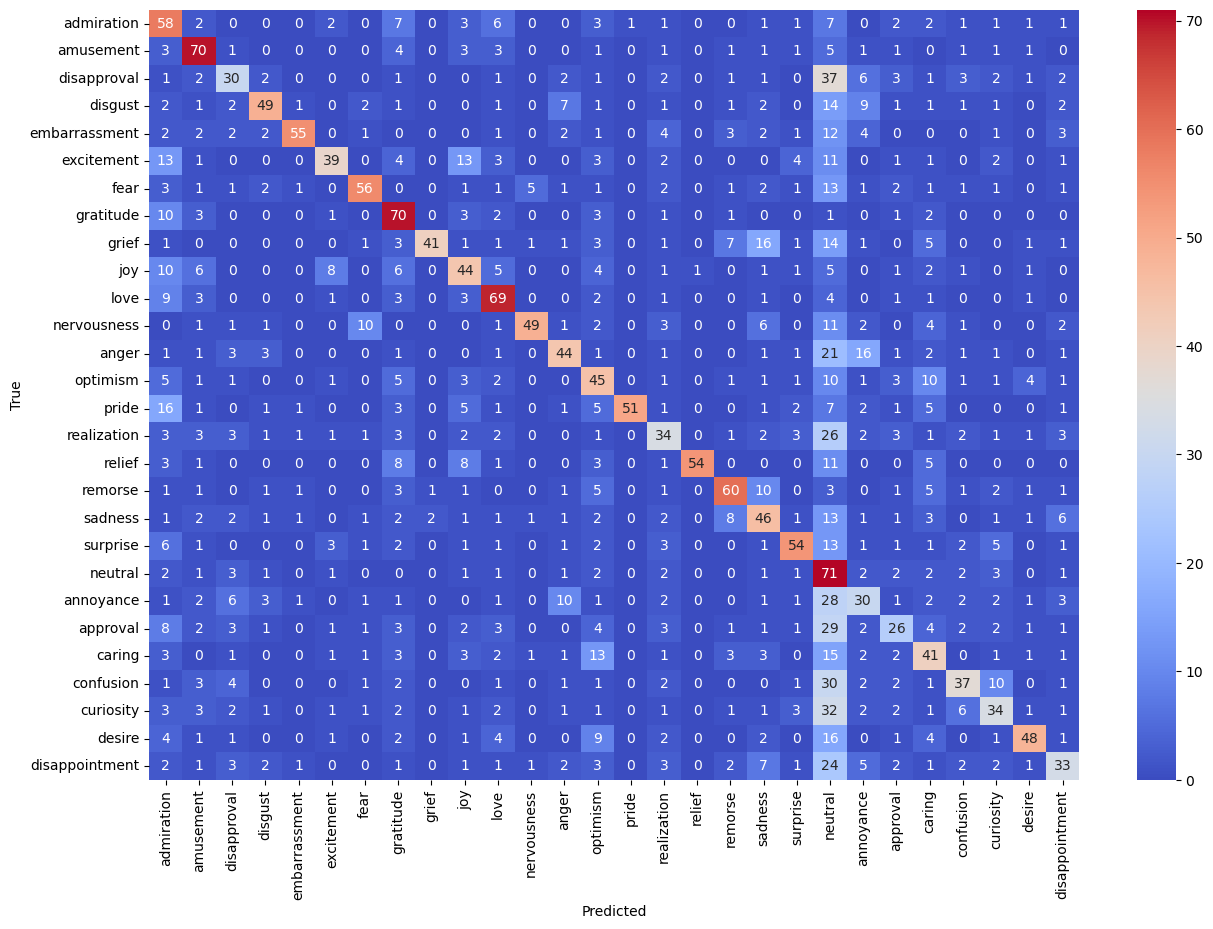

Val confusion matrix


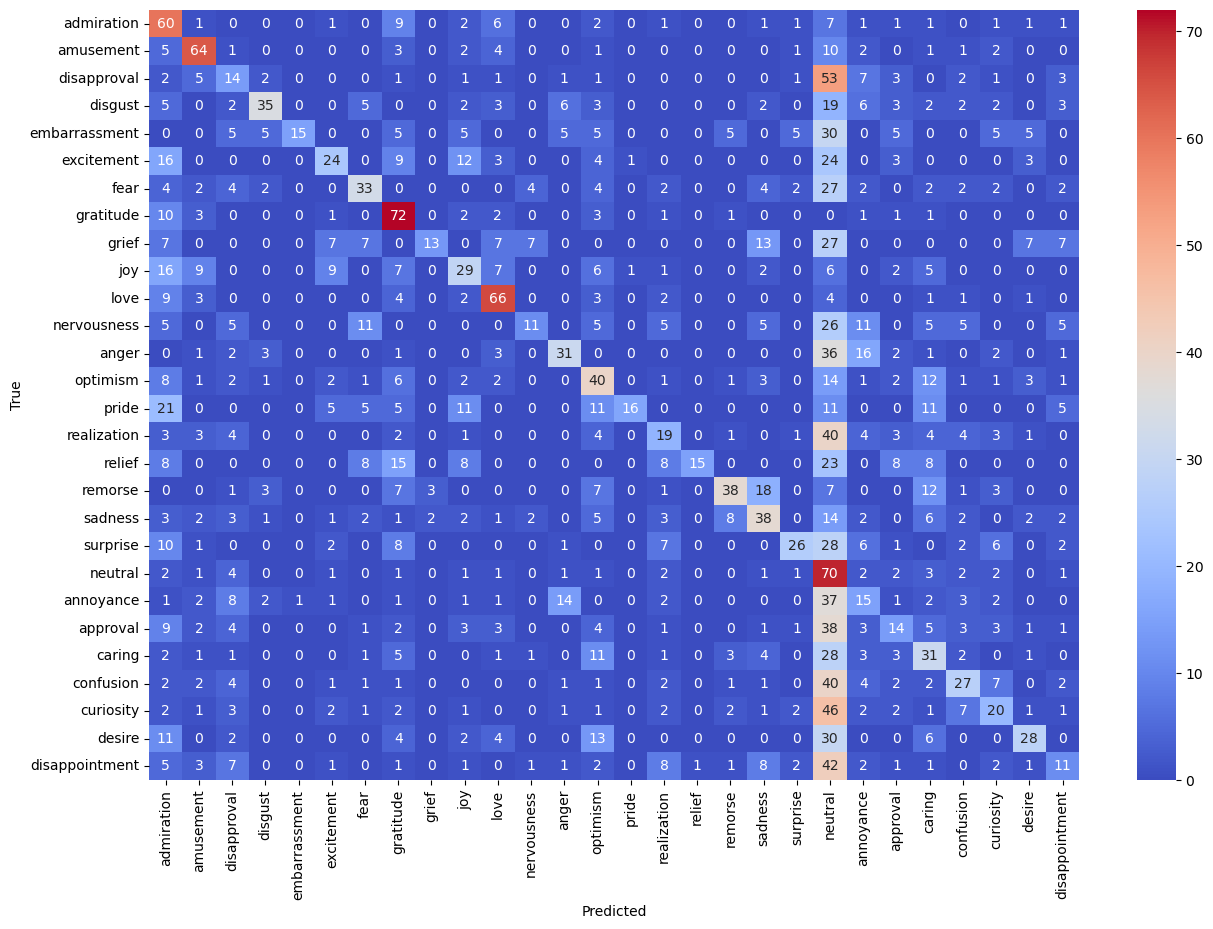

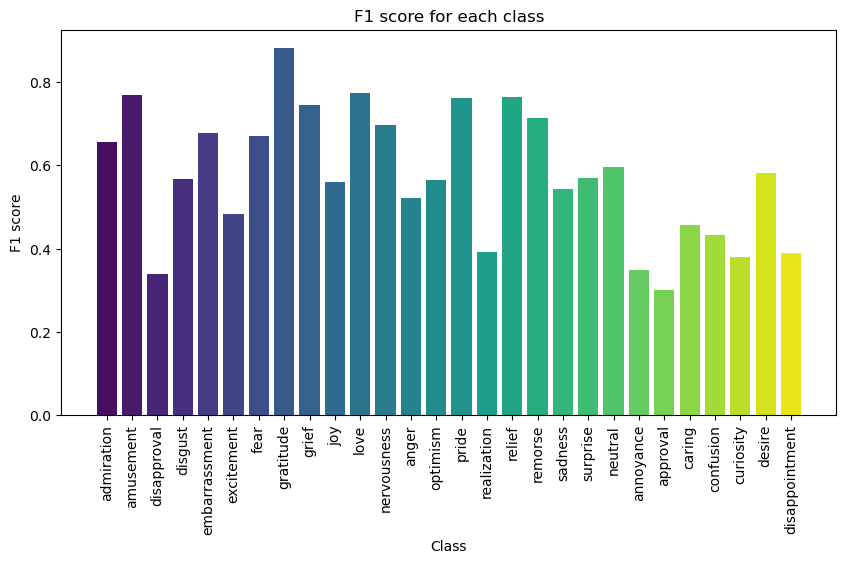

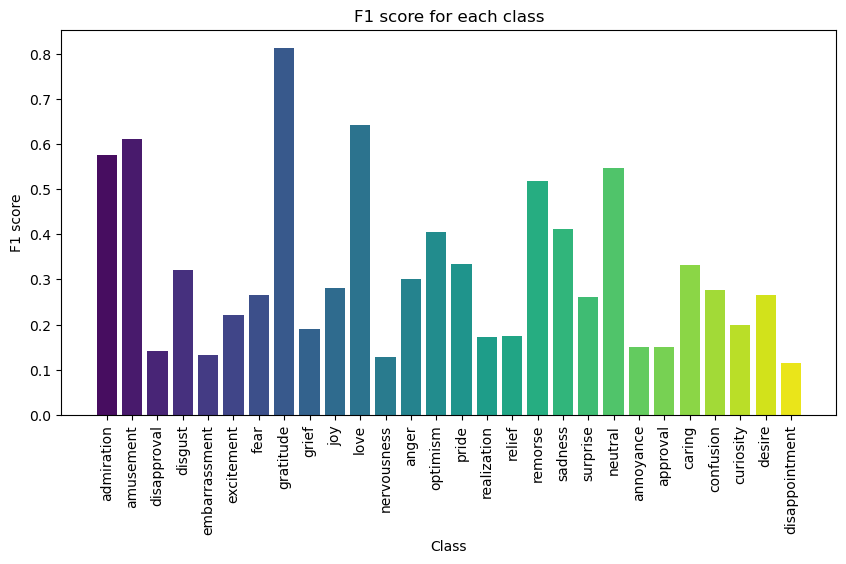

In [15]:
# test with only basic preprocessing (data preparation)
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

data preprocessing is ok, further cleaning yealded worse results

# Saving best models

In [6]:
CLASSIFIER_PATH = './checkpoints/GoEmotions/'
if not os.path.exists(CLASSIFIER_PATH):
    os.makedirs(CLASSIFIER_PATH)
NB_CLASSIFIER_PATH = CLASSIFIER_PATH + 'nb_classifier.pkl'
RESULTS_PATH = './results/GoEmotions/'

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.75                0.59                0.66                0.49                4130
amusement                           0.84                0.71                0.77                0.63                2328
disapproval                         0.45                0.27                0.34                0.20                2022
disgust                             0.70                0.48                0.57                0.39                 793
embarrassment                       0.75                0.62                0.68                0.51                 303
excitement                          0.58                0.41                0.48                0.32                 853
fear                                0.77                0.59                0.67                0.50                

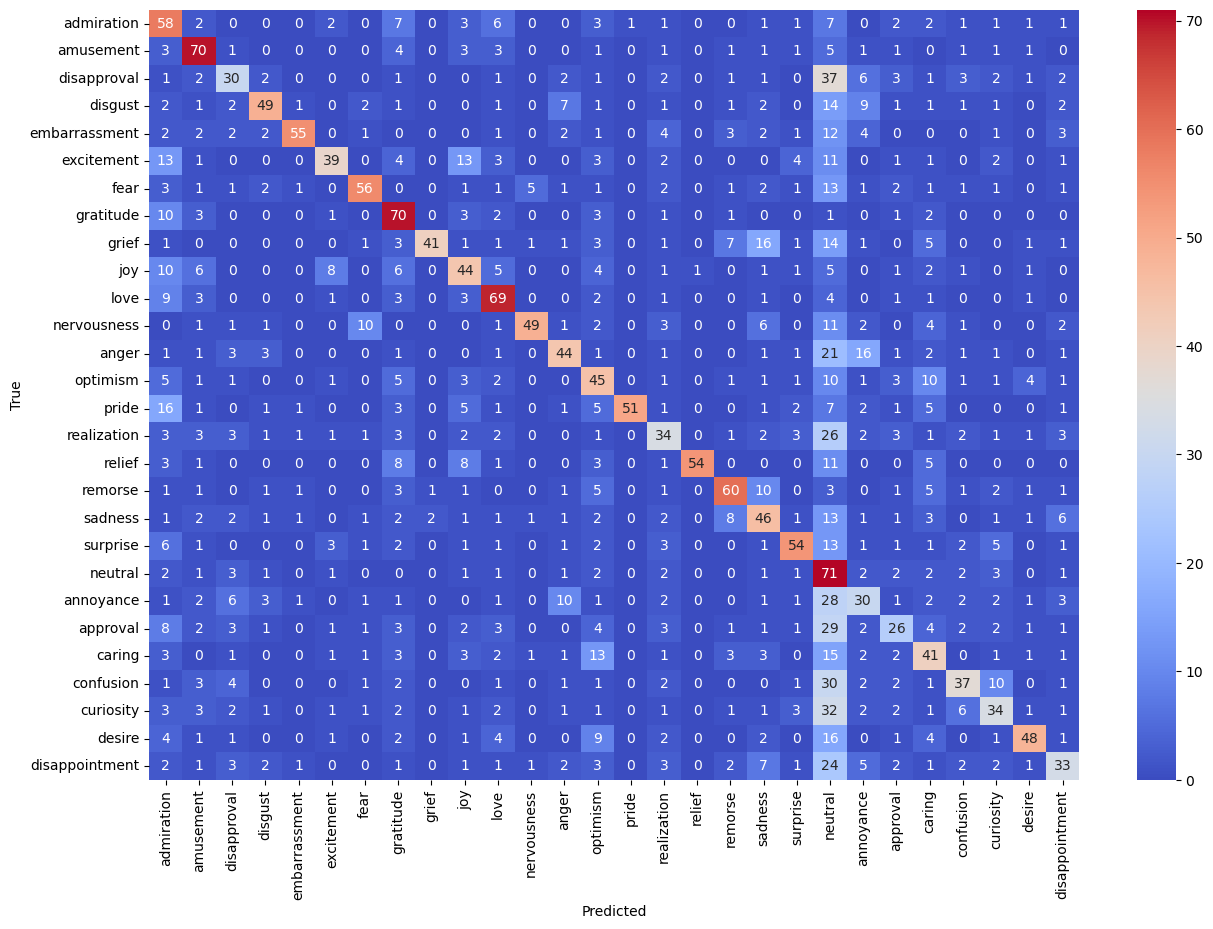

Val confusion matrix


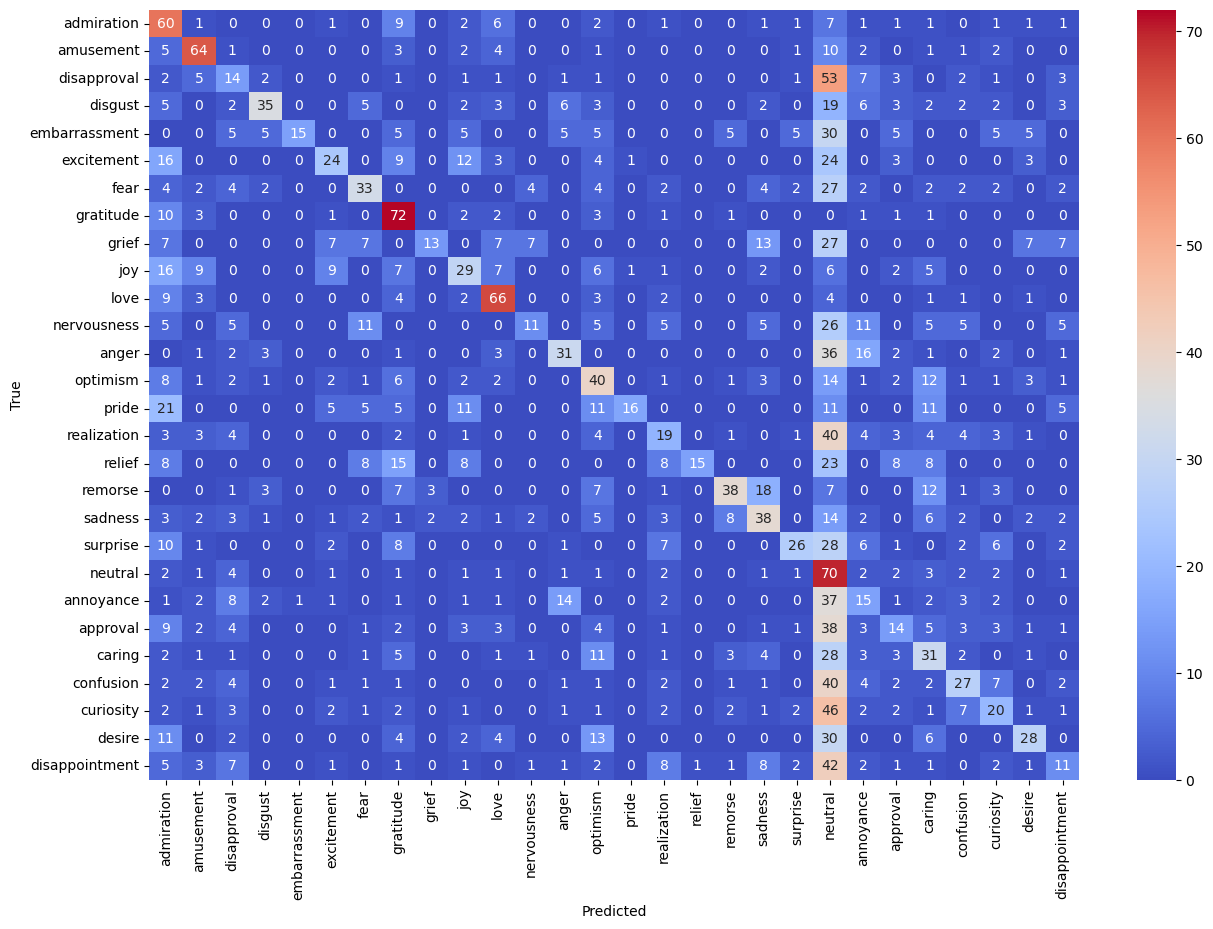

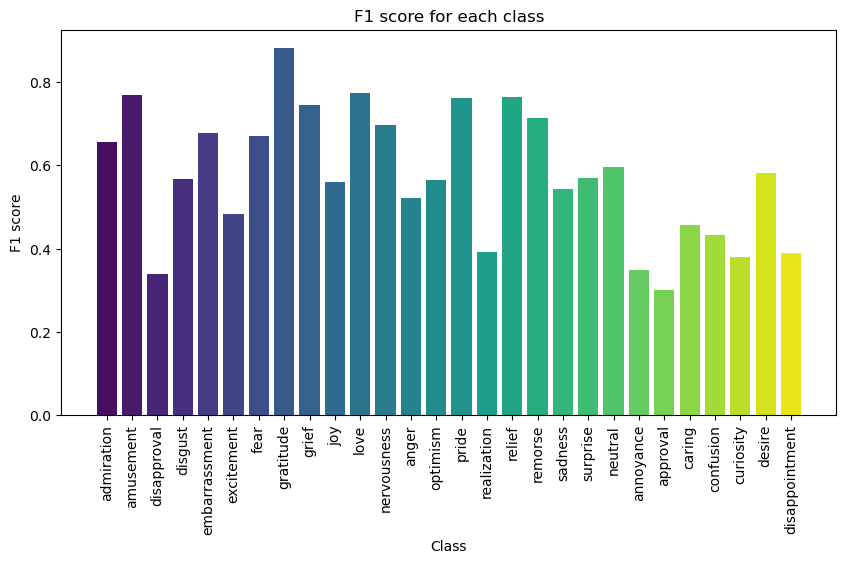

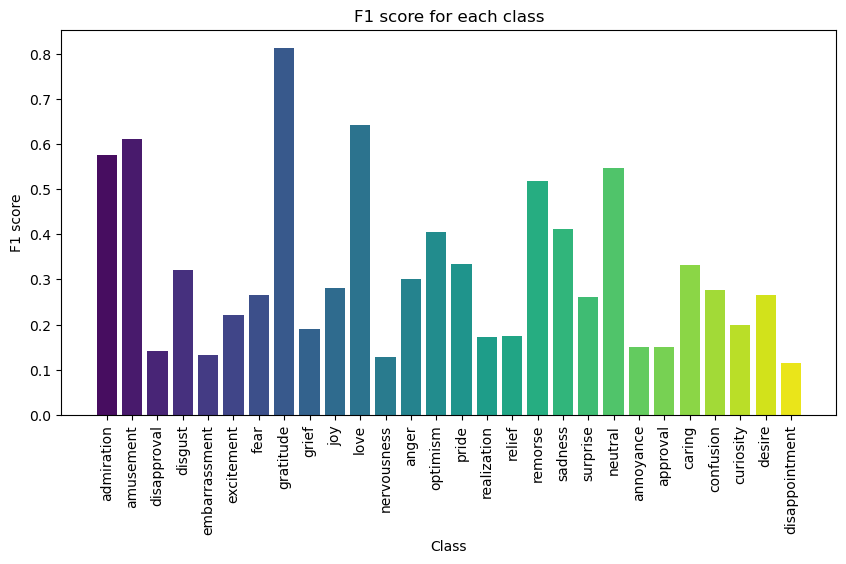

In [22]:
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS)

# save classifier
with open(NB_CLASSIFIER_PATH, 'wb') as f:
    pickle.dump(classifier, f)

## Features score

In [23]:
feature_importance = pd.DataFrame(columns=["word", "emotion", "score"])
for emotion, estimator in zip(LABELS, classifier.estimators_):
    ratio = estimator.named_steps['clf'].feature_log_prob_[0] / estimator.named_steps['clf'].feature_log_prob_[1]
    all_words = estimator.named_steps['vect'].get_feature_names_out()
    words = all_words[estimator.named_steps['select'].get_support()]
    feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": ratio})], ignore_index=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_17280\2013586385.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": ratio})], ignore_index=True)


In [24]:
feature_importance

word         emotion     score
0           10      admiration  1.009263
1           13      admiration  1.024350
2         2016      admiration  1.072838
3           25      admiration  0.816977
4           30      admiration  0.882772
...        ...             ...       ...
27995      you  disappointment  0.773075
27996     your  disappointment  0.829493
27997  youtube  disappointment  0.539910
27998     zero  disappointment  1.180853
27999     zion  disappointment  1.266435

[28000 rows x 3 columns]

In [25]:
# save csv
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
feature_importance.to_csv(RESULTS_PATH + 'GoEmotions_bayes_features.csv', index=False)

Word cloud for admiration


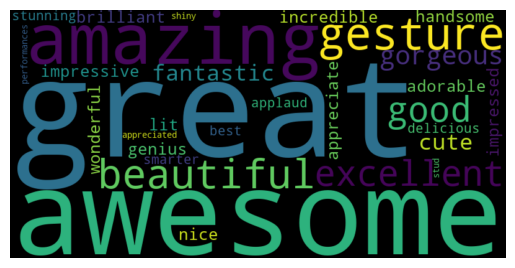

Word cloud for amusement


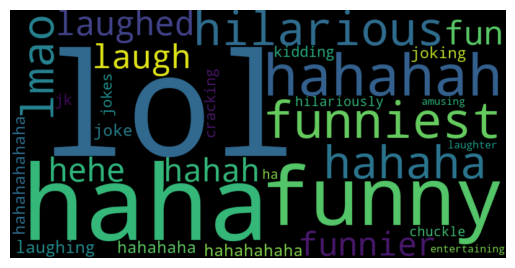

Word cloud for disapproval


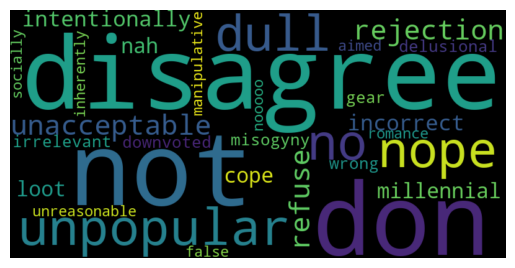

Word cloud for disgust


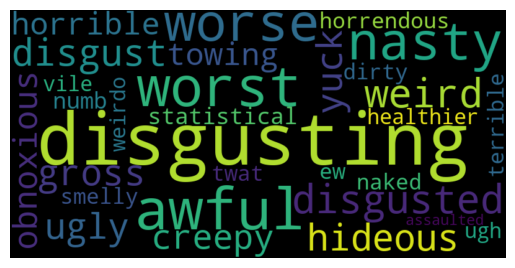

Word cloud for embarrassment


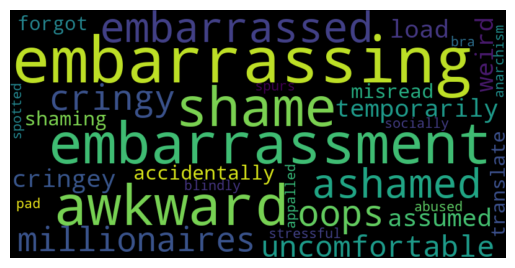

Word cloud for excitement


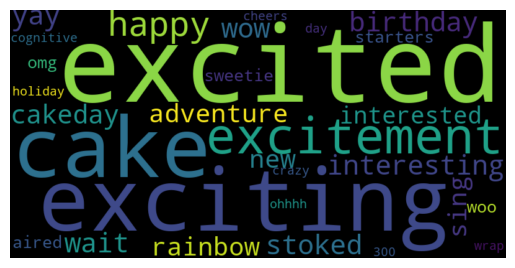

Word cloud for fear


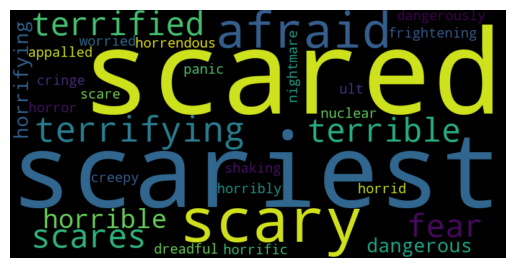

Word cloud for gratitude


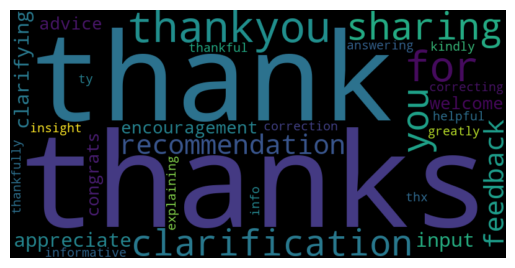

Word cloud for grief


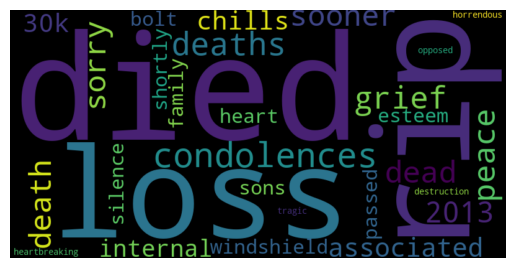

Word cloud for joy


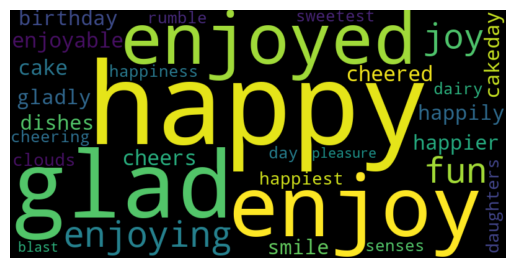

Word cloud for love


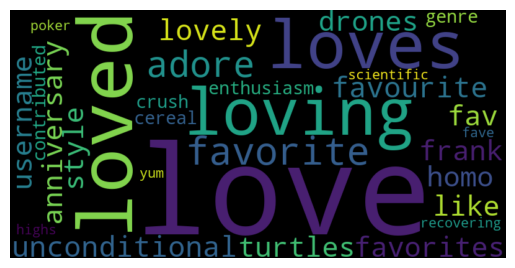

Word cloud for nervousness


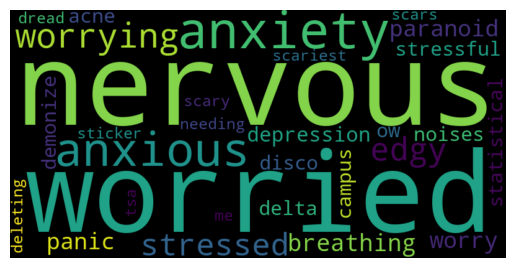

Word cloud for anger


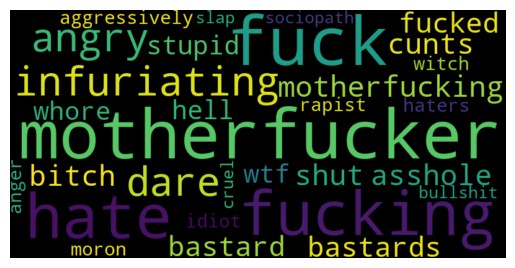

Word cloud for optimism


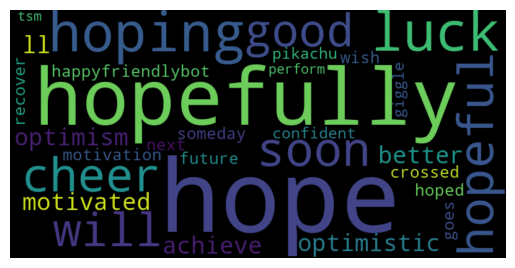

Word cloud for pride


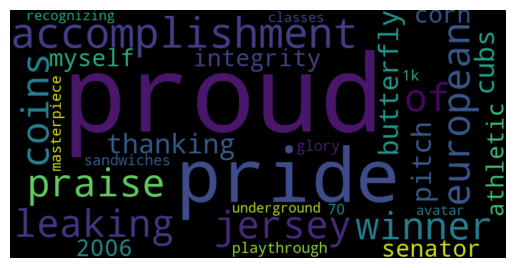

Word cloud for realization


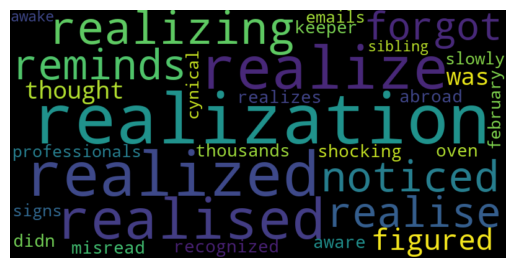

Word cloud for relief


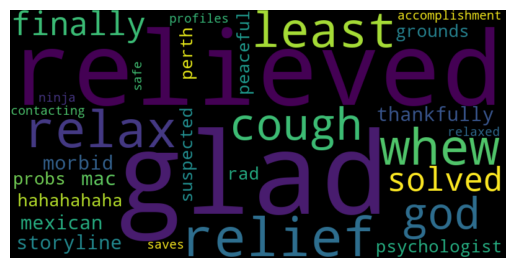

Word cloud for remorse


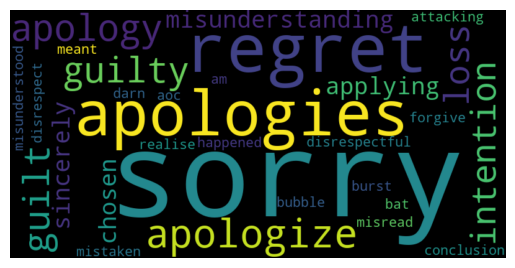

Word cloud for sadness


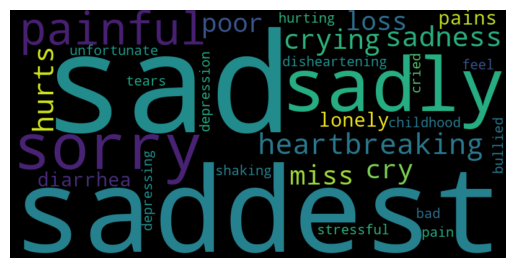

Word cloud for surprise


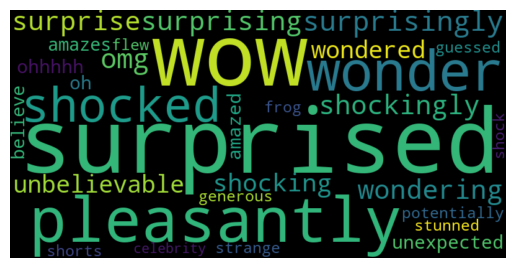

Word cloud for neutral


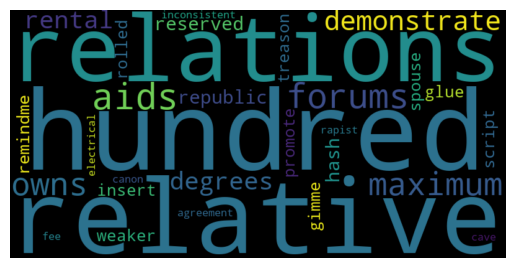

Word cloud for annoyance


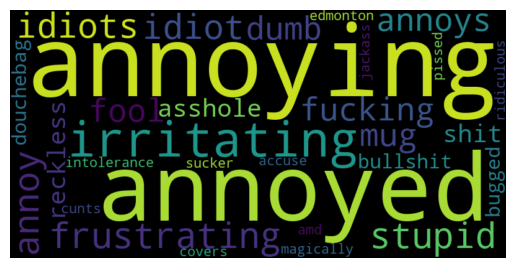

Word cloud for approval


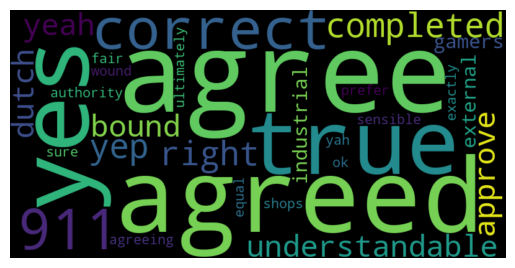

Word cloud for caring


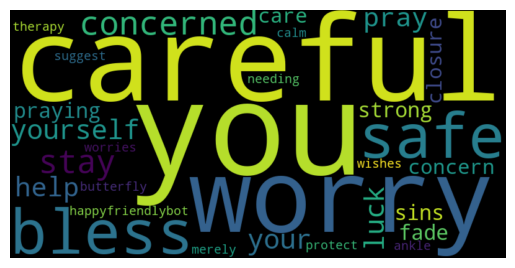

Word cloud for confusion


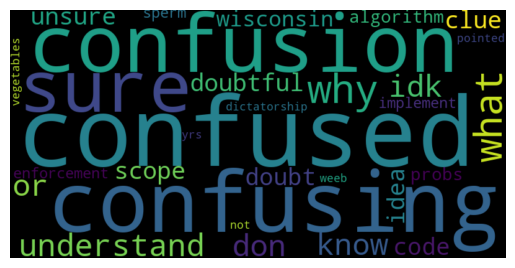

Word cloud for curiosity


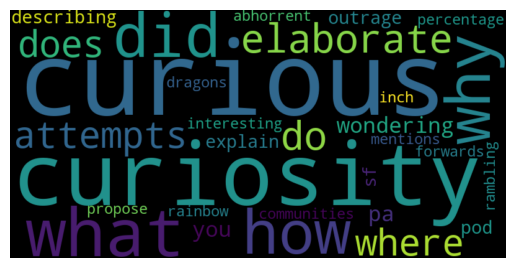

Word cloud for desire


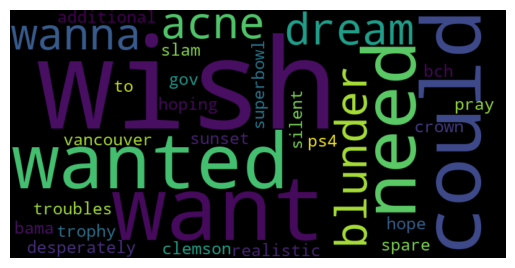

Word cloud for disappointment


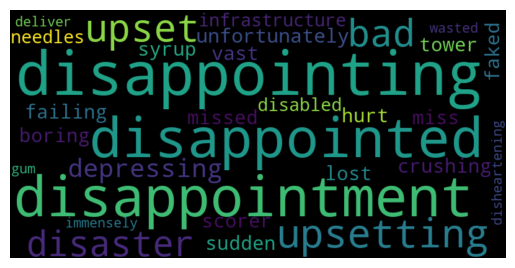

In [26]:
# word cloud of top 30 features for each class
N_TOP = 30
for label in LABELS:
    print(f'Word cloud for {label}')
    top_data = feature_importance[feature_importance['emotion'] == label].sort_values(by='score', ascending=False).head(N_TOP)
    wc = WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({row['word']: row['score'] for _, row in top_data.iterrows()})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Attempt with grouped labels

In [27]:
GROUPED_BAYES_FILE = CLASSIFIER_PATH + 'GoEmotions_grouped_bayes.pkl'

train_df = goemotions_apply_emotion_mapping(train_df)
val_df = goemotions_apply_emotion_mapping(val_df)
test_df = goemotions_apply_emotion_mapping(test_df)
# remove ekman_ prefix from label names
train_df.columns = train_df.columns.str.replace('ekman_', '')
val_df.columns = val_df.columns.str.replace('ekman_', '')
test_df.columns = test_df.columns.str.replace('ekman_', '')
LABELS_GROUPED = list(GOEMOTIONS_EKMAN_MAPPING.keys())
# remove ekman_ prefix from label names
LABELS_GROUPED = [label.replace('ekman_', '') for label in LABELS_GROUPED]

In [28]:
train_df

text  \
2                         WHY THE FUCK IS BAYLESS ISOING   
3                            To make her feel threatened   
4                                 Dirty Southern Wankers   
5      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...   
6      Yes I heard abt the f bombs! That has to be wh...   
...                                                  ...   
43405  Added you mate well I’ve just got the bow and ...   
43406  Always thought that was funny but is it a refe...   
43407  What are you talking about? Anything bad that ...   
43408            More like a baptism, with sexy results!   
43409                                    Enjoy the ride!   

                                              clean_text  joy  anger  \
2                         WHY THE FUCK IS BAYLESS ISOING    0      1   
3                              To make her feel threaten    0      0   
4                                 Dirty Southern Wankers    0      1   
5      OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...    0      0   
6      Yes I hear abt the f bomb That have to be why ...    1      0   
...                                                  ...  ...    ...   
43405  Added you mate well I ’ ve just get the bow an...    1      0   
43406  Always think that be funny but be it a referen...    0      0   
43407  What be you talk about Anything bad that happe...    0      1   
43408               More like a baptism with sexy result    1      0   
43409                                     Enjoy the ride    1      0   

       surprise  sadness  disgust  fear  
2             0        0        0     0  
3             0        0        0     1  
4             0        0        0     0  
5             1        0        0     0  
6             0        0        0     0  
...         ...      ...      ...   ...  
43405         0        0        0     0  
43406         1        0        0     0  
43407         0        0        0     0  
43408         0        0        0     0  
43409         0        0        0     0  

[30587 rows x 8 columns]

Train metrics
Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
joy                                 0.84                0.86                0.85                0.74               17410
anger                               0.68                0.51                0.58                0.41                5579
surprise                            0.66                0.47                0.55                0.38                5367
sadness                             0.75                0.54                0.63                0.46                3263
disgust                             0.68                0.52                0.59                0.42                 793
fear                                0.78                0.64                0.70                0.54                 726
Macro avg                           0.73                0.59                0.65                0.49               3

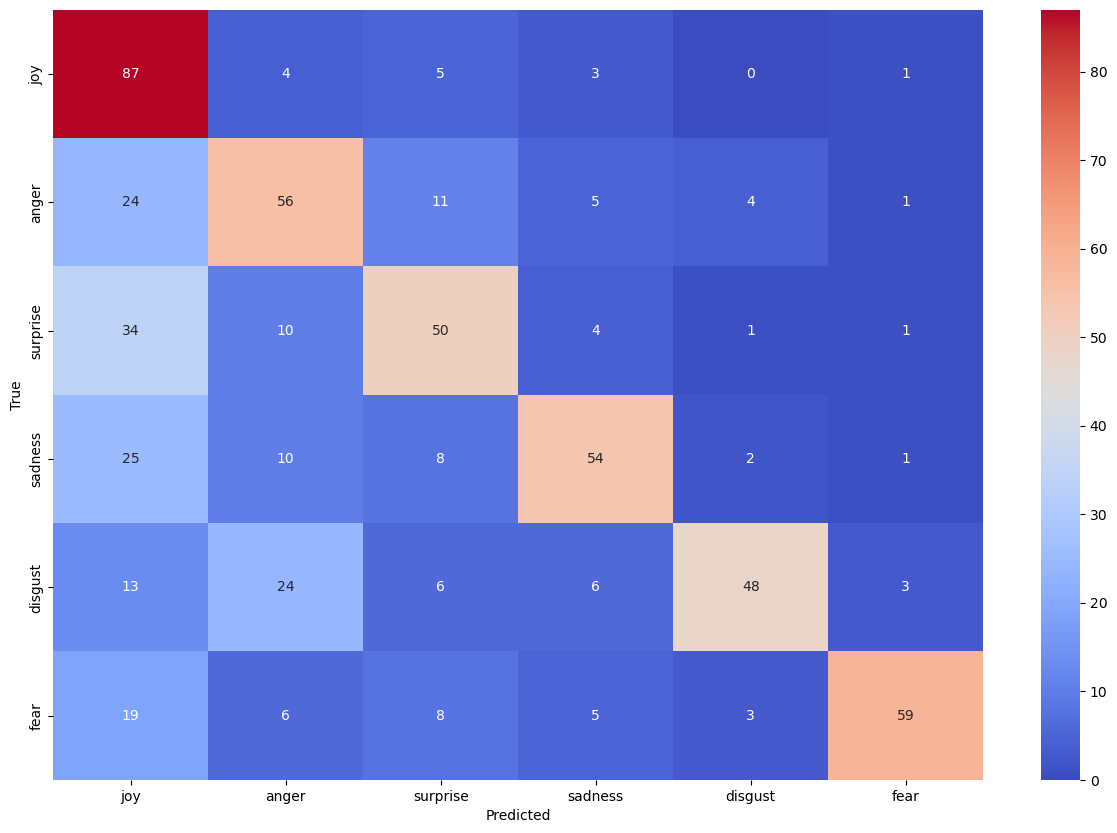

Val confusion matrix


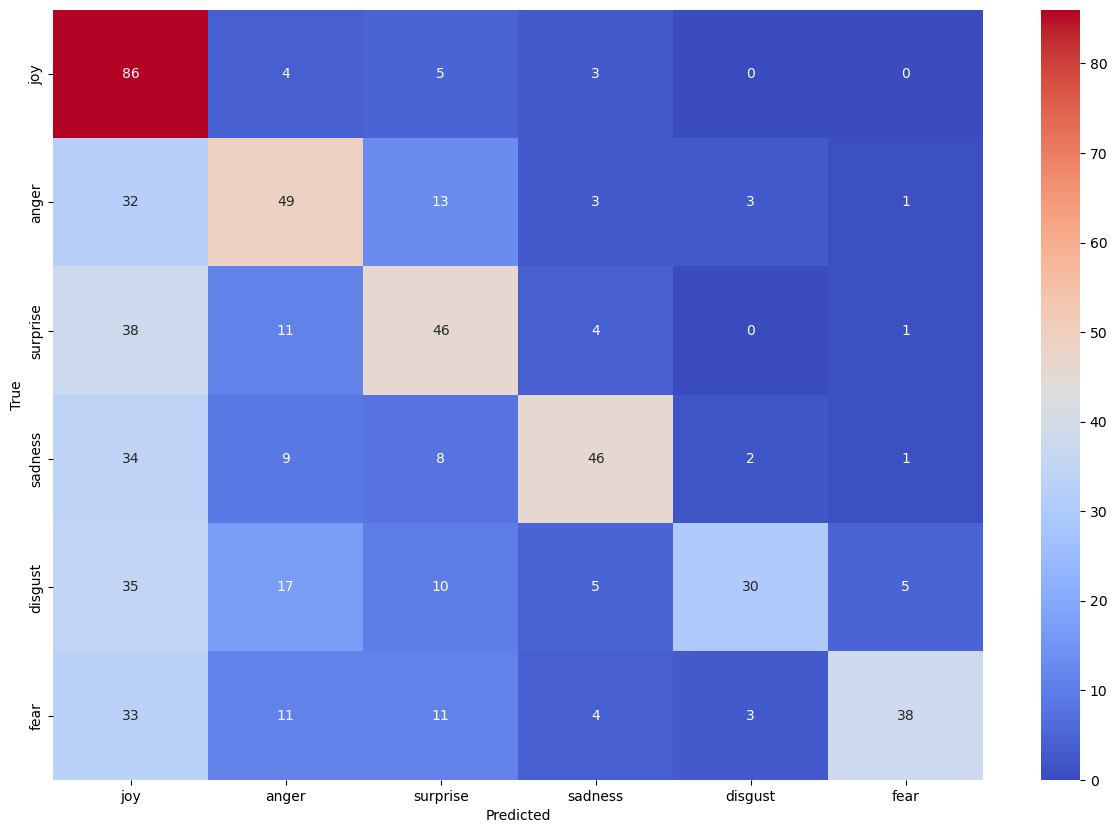

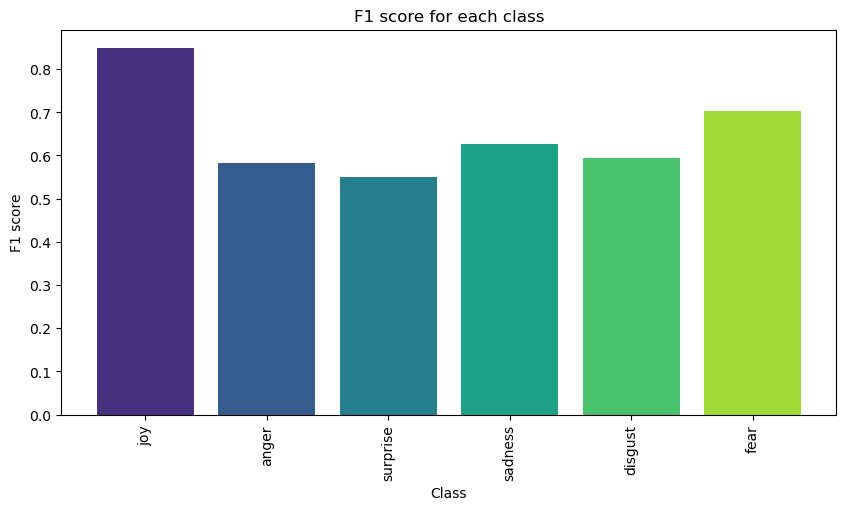

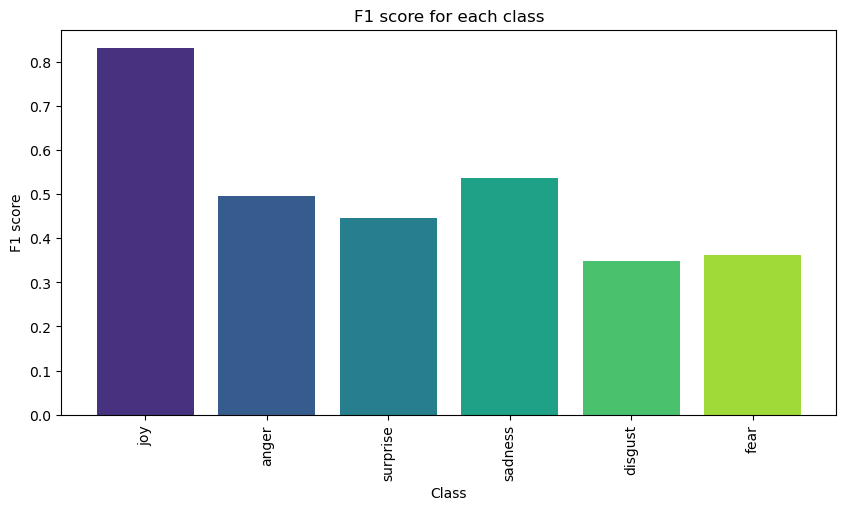

In [29]:
classifier = OneVsRestClassifier(Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('select', SelectKBest(mutual_info_classif, k=1000)),
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB(alpha=0.01))
]))

bayes_analysis(train_df, val_df, classifier, TEXT_COLUMN, LABELS_GROUPED)

# save classifier
with open(GROUPED_BAYES_FILE, 'wb') as f:
    pickle.dump(classifier, f)

## Features score

In [30]:
# load best random forest
with open(GROUPED_BAYES_FILE, 'rb') as f:
    classifier = pickle.load(f)

In [31]:
feature_importance = pd.DataFrame(columns=["word", "emotion", "score"])
for emotion, estimator in zip(LABELS_GROUPED, classifier.estimators_):
    ratio = estimator.named_steps['clf'].feature_log_prob_[0] / estimator.named_steps['clf'].feature_log_prob_[1]
    all_words = estimator.named_steps['vect'].get_feature_names_out()
    words = all_words[estimator.named_steps['select'].get_support()]
    feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": ratio})], ignore_index=True)

C:\Users\andre\AppData\Local\Temp\ipykernel_17280\2785983328.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_importance = pd.concat([feature_importance, pd.DataFrame({"word": words, "emotion": emotion, "score": ratio})], ignore_index=True)


In [32]:
feature_importance

word emotion     score
0           10     joy  1.023283
1           16     joy  0.891601
2          1st     joy  1.158169
3         2019     joy  1.062056
4           33     joy  0.548003
...        ...     ...       ...
5995     yours    fear  0.595605
5996  yourself    fear  0.767262
5997        yr    fear  1.293914
5998       yup    fear  0.580503
5999      zero    fear  1.172060

[6000 rows x 3 columns]

In [33]:
# save csv
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
feature_importance.to_csv(RESULTS_PATH + 'GoEmotions_grouped_bayes_features.csv', index=False)

Word cloud for joy


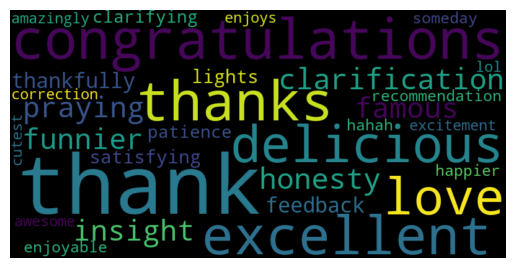

Word cloud for anger


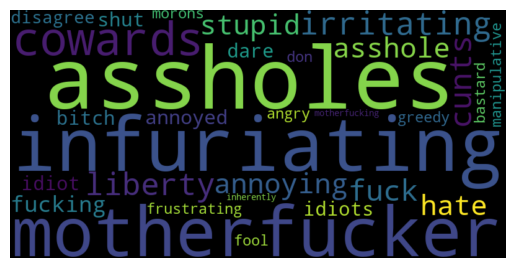

Word cloud for surprise


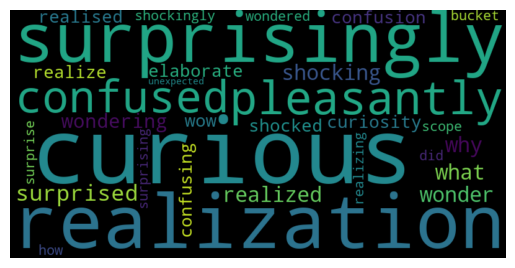

Word cloud for sadness


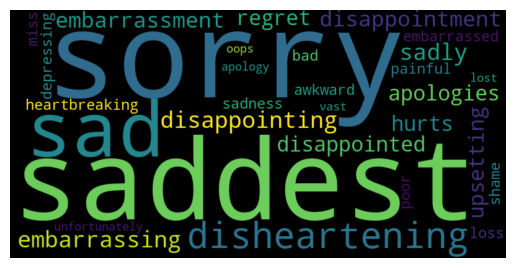

Word cloud for disgust


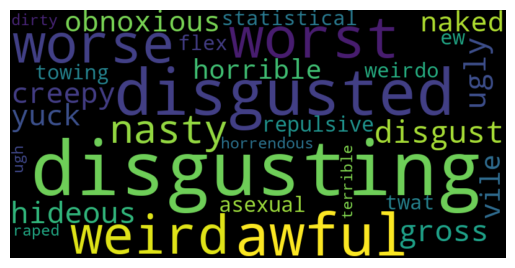

Word cloud for fear


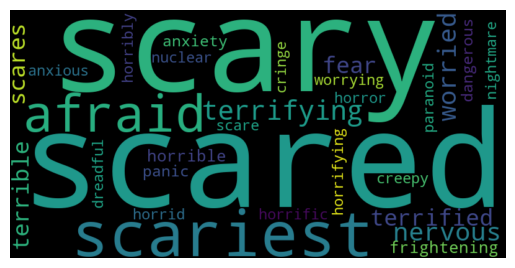

In [34]:
# word cloud of top 30 features for each class
N_TOP = 30
for label in LABELS_GROUPED:
    print(f'Word cloud for {label}')
    top_data = feature_importance[feature_importance['emotion'] == label].sort_values(by='score', ascending=False).head(N_TOP)
    wc = WordCloud(width=800, height=400, max_words=N_TOP).generate_from_frequencies({row['word']: row['score'] for _, row in top_data.iterrows()})
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Mapping analysis

Ekman Mapping


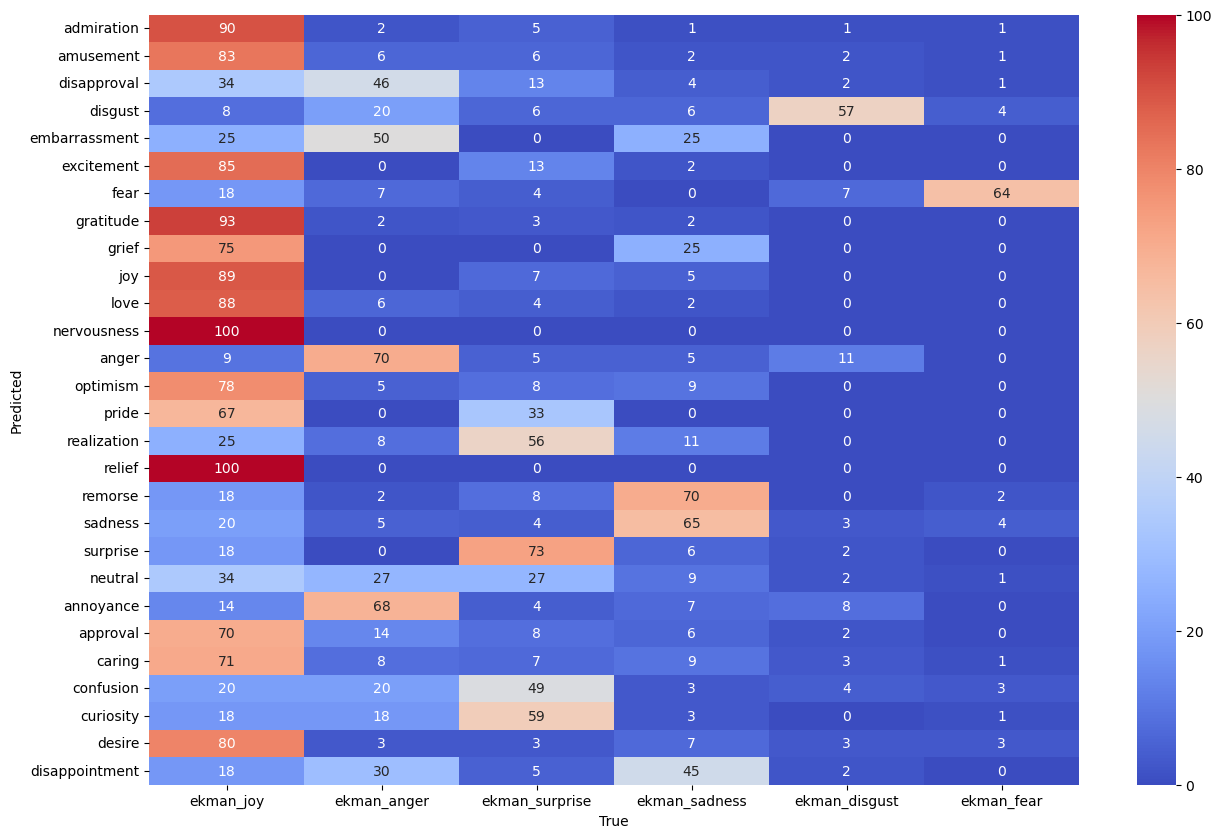

Parrott Mapping


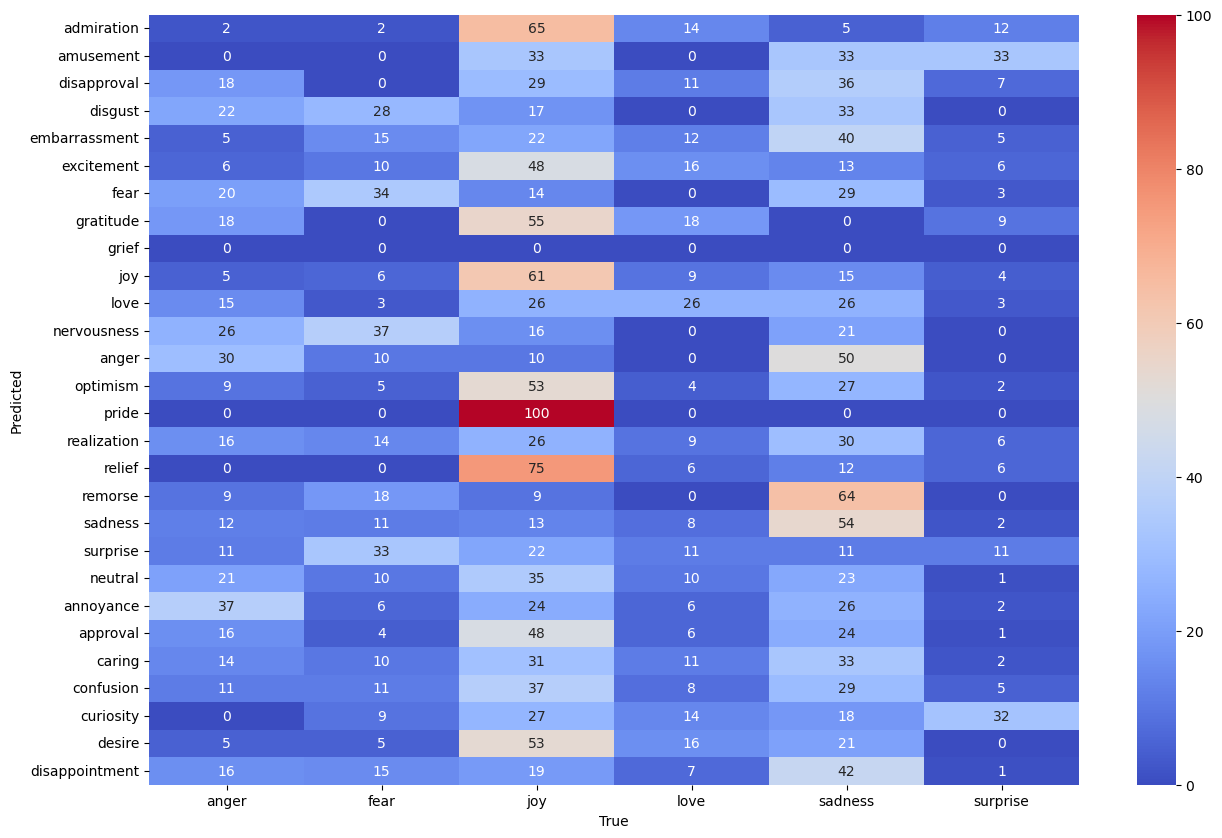

In [7]:
# load best model
with open(NB_CLASSIFIER_PATH, 'rb') as f:
    classifier = pickle.load(f)
# load dataset
_, _, test_df = load_dataset(DATASET)
# group labels
LABELS = test_df.columns[1:]
grouped_test_df = goemotions_apply_emotion_mapping(test_df)
GROUPED_LABELS = grouped_test_df.columns[1:].tolist()
# keep only records in grouped_test_df
test_df = test_df.loc[grouped_test_df.index]
# prediction on test
predictions_test = classifier.predict(grouped_test_df[TEXT_COLUMN])
# plot confusion matrix
print("Ekman Mapping")
plot_multilabel_confusion_heatmap(grouped_test_df[GROUPED_LABELS].values, predictions_test, GROUPED_LABELS, LABELS, normalize=True, transpose=True)
# mapping wrt twitter emotions
_, _, test_df = load_dataset(DatasetEnum.TwitterDataCleaned)
TWITTER_LABELS = test_df.columns[1:].tolist()
predictions_test = classifier.predict(test_df[TEXT_COLUMN])
print("Parrott Mapping")
plot_multilabel_confusion_heatmap(test_df[TWITTER_LABELS].values, predictions_test, TWITTER_LABELS, LABELS, normalize=True, transpose=True)